In [1]:
# Cell 1: Setup
import os, sys, json, math, time, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Project directories (edit if you want a different root)
PROJ = Path.cwd()
DATA = Path(r"C:\Users\nikhi\Music\ECG\data")  # <-- your local path
FIGS = PROJ / "figures"; FIGS.mkdir(exist_ok=True)
RESULTS = PROJ / "results"; RESULTS.mkdir(exist_ok=True)

# Fallback (for running inside this session, ignore locally)
if not (DATA / "mitbih_train.csv").exists():
    DATA = Path("/mnt/data")

TRAIN_PATH = DATA / "mitbih_train.csv"
TEST_PATH = DATA / "mitbih_test.csv"

assert TRAIN_PATH.exists() and TEST_PATH.exists(), "CSV files not found at expected paths."

# Matplotlib defaults (do not set colors per instruction)
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["axes.grid"] = True

print("Project:", PROJ)
print("Data folder:", DATA)
print("Figures folder:", FIGS)
print("Results folder:", RESULTS)


Project: C:\Users\nikhi\Music\ECG
Data folder: C:\Users\nikhi\Music\ECG\data
Figures folder: C:\Users\nikhi\Music\ECG\figures
Results folder: C:\Users\nikhi\Music\ECG\results


In [2]:
# Cell 2: Load CSVs
df_train = pd.read_csv(TRAIN_PATH, header=None)
df_test  = pd.read_csv(TEST_PATH, header=None)

# MIT-BIH Kaggle format: 187 time samples + 1 label = 188 columns
n_cols = df_train.shape[1]
feature_cols = list(range(n_cols - 1))
label_col = n_cols - 1

df_train.columns = feature_cols + ["label"]
df_test.columns  = feature_cols + ["label"]

print("Train shape:", df_train.shape)
print("Test  shape:", df_test.shape)
print("n_features:", len(feature_cols))
print("Label set (train):", sorted(df_train["label"].unique().tolist()))
print("Label set (test) :", sorted(df_test["label"].unique().tolist()))


Train shape: (87554, 188)
Test  shape: (21892, 188)
n_features: 187
Label set (train): [0.0, 1.0, 2.0, 3.0, 4.0]
Label set (test) : [0.0, 1.0, 2.0, 3.0, 4.0]


In [3]:
# Cell 5: Quick peek at a few rows
display(df_train.head(5))
display(df_test.head(5))


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Cell 3: Summary & integrity
def class_counts(df):
    vc = df["label"].value_counts().sort_index()
    idx = [0,1,2,3,4]
    return vc.reindex(idx).fillna(0).astype(int)

summary = {
    "train_shape": df_train.shape,
    "test_shape": df_test.shape,
    "n_features": len(feature_cols),
    "train_missing_values": int(df_train.isna().sum().sum()),
    "test_missing_values": int(df_test.isna().sum().sum()),
    "train_duplicates": int(df_train.duplicated().sum()),
    "test_duplicates": int(df_test.duplicated().sum()),
    "feature_min": float(df_train[feature_cols].to_numpy().min()),
    "feature_max": float(df_train[feature_cols].to_numpy().max()),
    "feature_mean": float(df_train[feature_cols].to_numpy().mean()),
    "feature_std": float(df_train[feature_cols].to_numpy().std()),
    "train_class_counts": class_counts(df_train).to_dict(),
    "test_class_counts": class_counts(df_test).to_dict(),
}

display(pd.DataFrame({"metric": list(summary.keys()), "value": list(summary.values())}))


,metric,value
0,train_shape,"(87554, 188)"
1,test_shape,"(21892, 188)"
2,n_features,187
3,train_missing_values,0
4,test_missing_values,0
5,train_duplicates,0
6,test_duplicates,0
7,feature_min,0.0
8,feature_max,1.0
9,feature_mean,0.174283


,class,count
0,N (Normal),90589
1,S (Supraventricular ectopic),2779
2,V (Ventricular ectopic),7236
3,F (Fusion),803
4,Q (Unknown/Other),8039


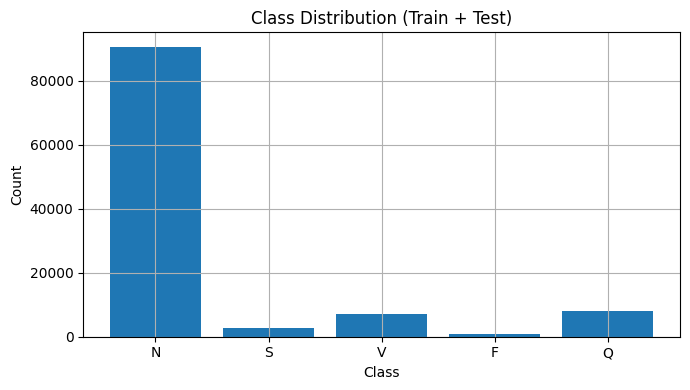

Saved figure: C:\Users\nikhi\Music\ECG\figures\class_distribution_all.png


In [5]:
# Cell 4: Class names and combined distribution plot
class_map = {
    0: "N (Normal)",
    1: "S (Supraventricular ectopic)",
    2: "V (Ventricular ectopic)",
    3: "F (Fusion)",
    4: "Q (Unknown/Other)",
}
df_train["class_name"] = df_train["label"].map(class_map)
df_test["class_name"]  = df_test["label"].map(class_map)

df_all = pd.concat([df_train.assign(split="train"), df_test.assign(split="test")], ignore_index=True)

dist_all = class_counts(df_all)
display(pd.DataFrame({"class": list(class_map.values()), "count": dist_all.values}))

# Bar chart (combined)
plt.figure()
plt.bar(["N","S","V","F","Q"], dist_all.values)
plt.title("Class Distribution (Train + Test)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
out_path = FIGS / "class_distribution_all.png"
plt.savefig(out_path, dpi=150); plt.show()
print("Saved figure:", out_path)


In [6]:
# Cell 6: Feature-wise stats
feat_stats = pd.DataFrame({
    "feature_idx": feature_cols,
    "mean": df_train[feature_cols].mean().to_numpy(),
    "std":  df_train[feature_cols].std().to_numpy(),
    "min":  df_train[feature_cols].min().to_numpy(),
    "max":  df_train[feature_cols].max().to_numpy(),
})
display(feat_stats.head(10))


,feature_idx,mean,std,min,max
0,0,0.890360,0.240909,0.0,1.0
1,1,0.758160,0.221813,0.0,1.0
2,2,0.423972,0.227305,0.0,1.0
3,3,0.219104,0.206878,0.0,1.0
4,4,0.201127,0.177058,0.0,1.0
5,5,0.210399,0.171909,0.0,1.0
6,6,0.205808,0.178481,0.0,1.0
7,7,0.201773,0.177240,0.0,1.0
8,8,0.198691,0.171778,0.0,1.0
9,9,0.196757,0.168357,0.0,1.0


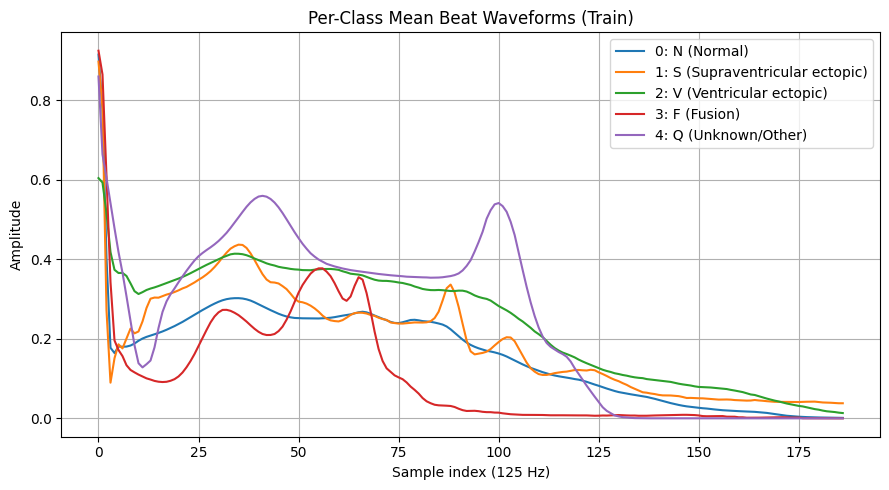

Saved figure: C:\Users\nikhi\Music\ECG\figures\per_class_mean_waveforms.png


In [7]:
# Cell 7: Per-class mean waveform
x_axis = np.arange(len(feature_cols))

plt.figure(figsize=(9,5))
for c in range(5):
    Xc = df_train.loc[df_train["label"]==c, feature_cols].to_numpy()
    if len(Xc) == 0: 
        continue
    m = Xc.mean(axis=0)
    plt.plot(x_axis, m, label=f"{c}: {class_map[c]}")
plt.title("Per-Class Mean Beat Waveforms (Train)")
plt.xlabel("Sample index (125 Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
out_path = FIGS / "per_class_mean_waveforms.png"
plt.savefig(out_path, dpi=150); plt.show()
print("Saved figure:", out_path)


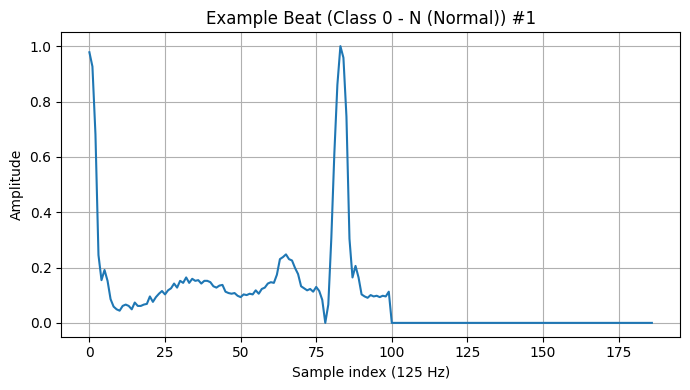

Saved figure: C:\Users\nikhi\Music\ECG\figures\example_c0_1.png


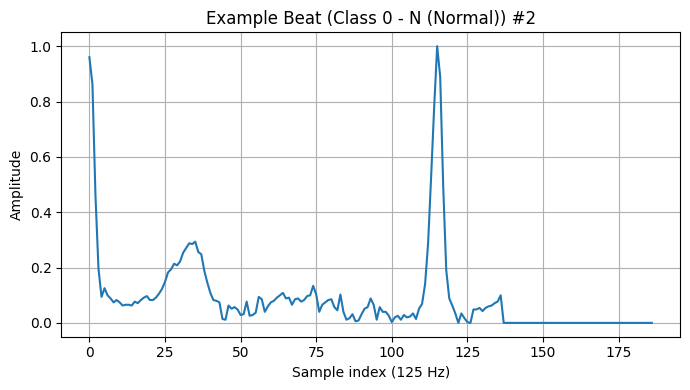

Saved figure: C:\Users\nikhi\Music\ECG\figures\example_c0_2.png


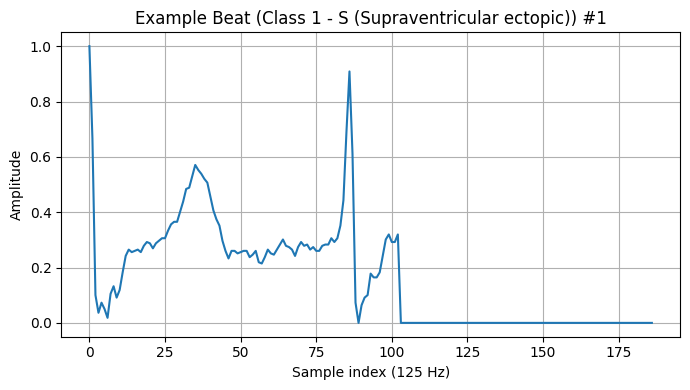

Saved figure: C:\Users\nikhi\Music\ECG\figures\example_c1_1.png


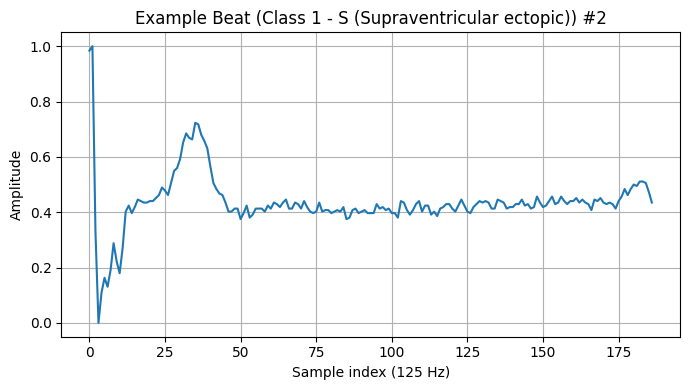

Saved figure: C:\Users\nikhi\Music\ECG\figures\example_c1_2.png


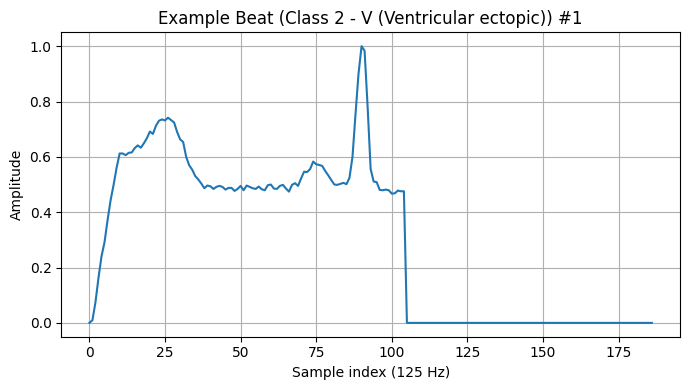

Saved figure: C:\Users\nikhi\Music\ECG\figures\example_c2_1.png


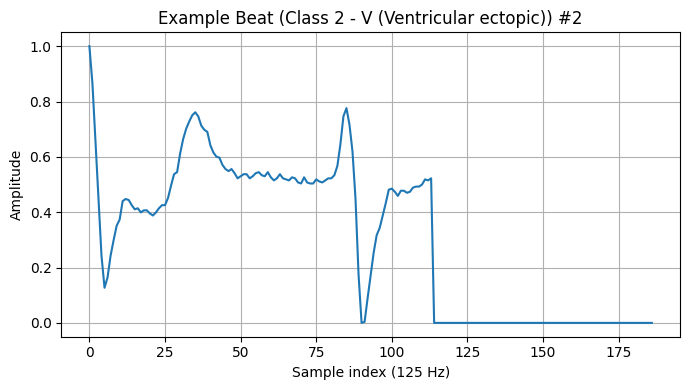

Saved figure: C:\Users\nikhi\Music\ECG\figures\example_c2_2.png


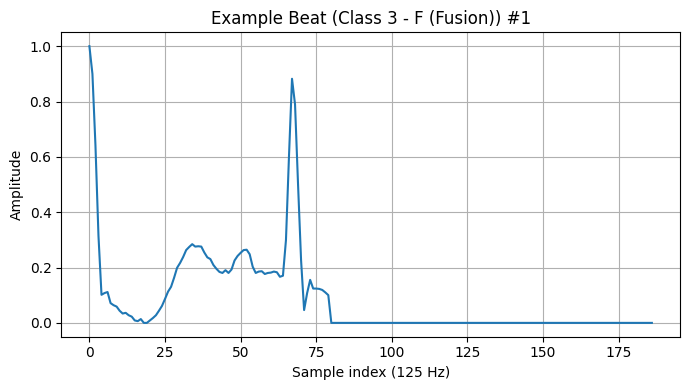

Saved figure: C:\Users\nikhi\Music\ECG\figures\example_c3_1.png


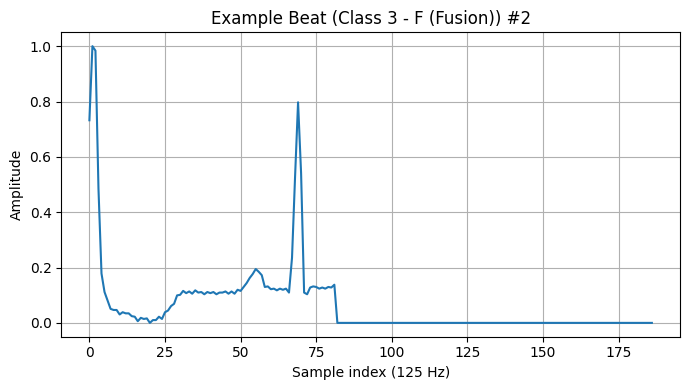

Saved figure: C:\Users\nikhi\Music\ECG\figures\example_c3_2.png


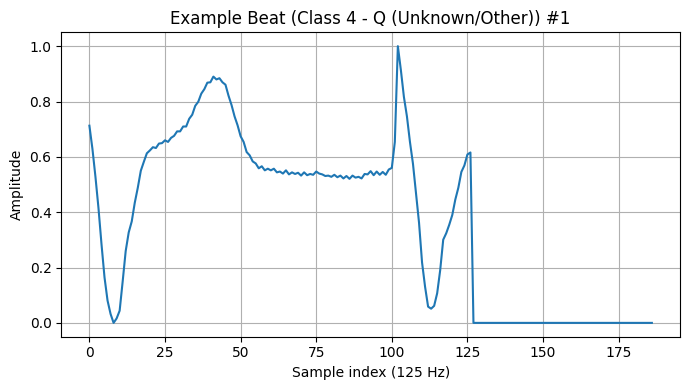

Saved figure: C:\Users\nikhi\Music\ECG\figures\example_c4_1.png


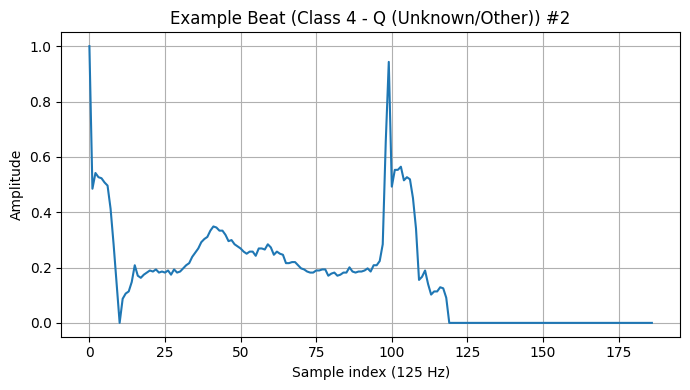

Saved figure: C:\Users\nikhi\Music\ECG\figures\example_c4_2.png


In [8]:
# Cell 8: Example waveforms per class (2 each)
for c in range(5):
    examples = df_train[df_train["label"]==c].head(2)
    for i, (_, row) in enumerate(examples.iterrows(), start=1):
        plt.figure()
        plt.plot(x_axis, row[feature_cols].to_numpy())
        plt.title(f"Example Beat (Class {c} - {class_map[c]}) #{i}")
        plt.xlabel("Sample index (125 Hz)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        out_path = FIGS / f"example_c{c}_{i}.png"
        plt.savefig(out_path, dpi=150); plt.show()
        print("Saved figure:", out_path)


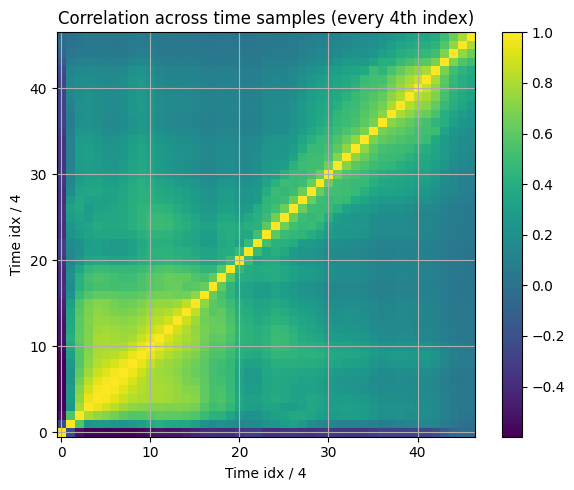

Saved figure: C:\Users\nikhi\Music\ECG\figures\corr_time_samples_heatmap.png


In [9]:
# Cell 9: Correlation matrix across time samples (downsample to avoid huge figure)
# We'll compute correlation but visualize only every 4th sample to keep it readable.
corr = df_train[feature_cols].corr().to_numpy()

step = 4
corr_small = corr[::step, ::step]

plt.figure(figsize=(6,5))
plt.imshow(corr_small, aspect='auto', origin='lower')
plt.title("Correlation across time samples (every 4th index)")
plt.xlabel("Time idx / 4")
plt.ylabel("Time idx / 4")
plt.colorbar()
plt.tight_layout()
out_path = FIGS / "corr_time_samples_heatmap.png"
plt.savefig(out_path, dpi=150); plt.show()
print("Saved figure:", out_path)


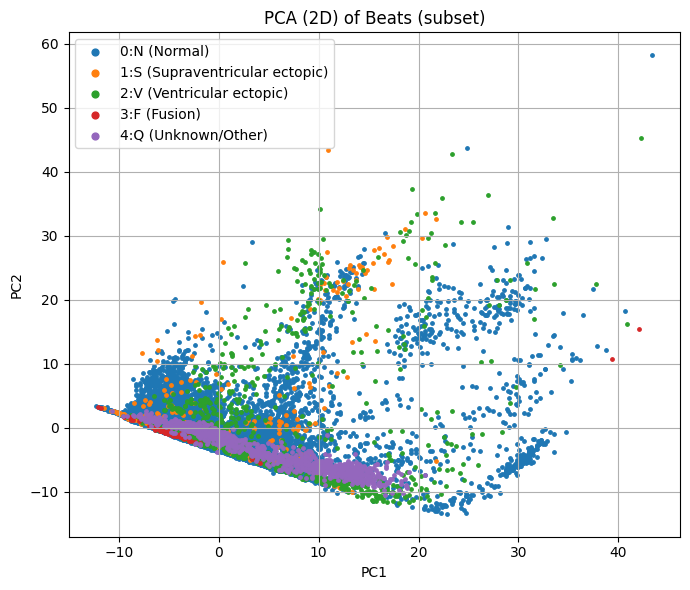

Saved figure: C:\Users\nikhi\Music\ECG\figures\pca_2d_subset.png
Explained variance ratio: [0.36860463 0.15462056]


In [10]:
# Cell 10: PCA (2D) on a sampled subset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sample_df = df_all.copy()
if len(sample_df) > 15000:
    sample_df = sample_df.sample(15000, random_state=SEED)

X = sample_df[feature_cols].to_numpy().astype(np.float32)
y = sample_df["label"].to_numpy().astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
for c in range(5):
    mask = (y==c)
    plt.scatter(X_pca[mask,0], X_pca[mask,1], s=6, label=f"{c}:{class_map[c]}")
plt.title("PCA (2D) of Beats (subset)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=2)
plt.tight_layout()
out_path = FIGS / "pca_2d_subset.png"
plt.savefig(out_path, dpi=150); plt.show()
print("Saved figure:", out_path)

print("Explained variance ratio:", pca.explained_variance_ratio_)


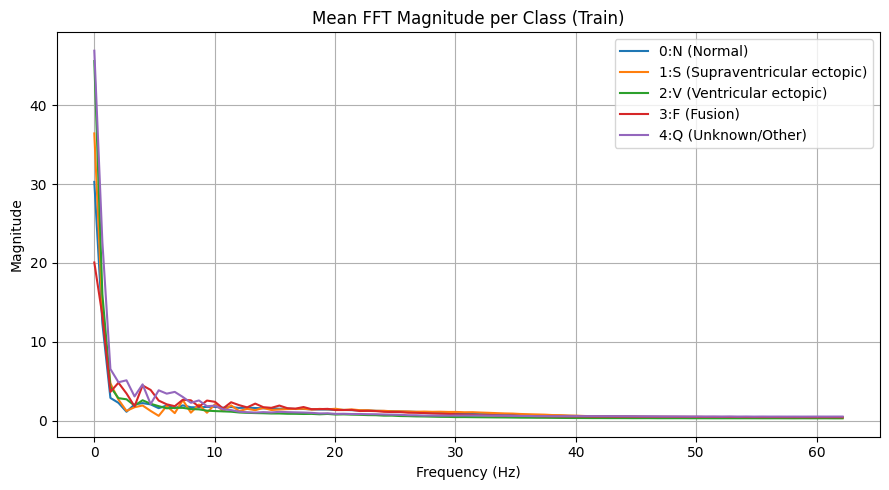

Saved figure: C:\Users\nikhi\Music\ECG\figures\fft_mean_per_class.png


In [11]:
# Cell 11: FFT magnitude (per-class mean)
fs = 125.0  # Hz
freqs = np.fft.rfftfreq(len(feature_cols), d=1.0/fs)

plt.figure(figsize=(9,5))
for c in range(5):
    Xc = df_train.loc[df_train["label"]==c, feature_cols].to_numpy()
    if len(Xc) == 0: 
        continue
    m = Xc.mean(axis=0)
    M = np.abs(np.fft.rfft(m))
    plt.plot(freqs, M, label=f"{c}:{class_map[c]}")
plt.title("Mean FFT Magnitude per Class (Train)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.tight_layout()
out_path = FIGS / "fft_mean_per_class.png"
plt.savefig(out_path, dpi=150); plt.show()
print("Saved figure:", out_path)


In [12]:
# Cell 13: Stratified train/val split (preview)
from sklearn.model_selection import train_test_split

X_tr = df_train[feature_cols].to_numpy().astype(np.float32)
y_tr = df_train["label"].to_numpy().astype(int)

X_tr_in, X_val_in, y_tr_in, y_val_in = train_test_split(
    X_tr, y_tr, test_size=0.10, random_state=SEED, stratify=y_tr
)

def vc(y):
    vals, cnts = np.unique(y, return_counts=True)
    return dict(zip(vals.tolist(), cnts.tolist()))

print("Train split counts:", vc(y_tr_in))
print("Val split counts  :", vc(y_val_in))


Train split counts: {0: 65223, 1: 2001, 2: 5209, 3: 577, 4: 5788}
Val split counts  : {0: 7248, 1: 222, 2: 579, 3: 64, 4: 643}


In [13]:
# Cell 16: Phase 2 config & utilities

import json, math, random
import numpy as np
import pandas as pd
from pathlib import Path

# Reuse globals from Phase 1: PROJ, DATA, FIGS, RESULTS, SEED, df_train, df_test, feature_cols, class_map
random.seed(SEED); np.random.seed(SEED)

# Helper: class counts and pretty print
def class_counts_np(y):
    vals, cnts = np.unique(y, return_counts=True)
    d = {int(k): int(v) for k, v in zip(vals, cnts)}
    for i in range(5):
        d.setdefault(i, 0)
    return d

def print_counts(title, y):
    d = class_counts_np(y)
    print(title, "→", d, " | total:", sum(d.values()))

# Use the stratified split preview from Phase 1 (Cell 13) or recompute here:
from sklearn.model_selection import train_test_split
X_tr_all = df_train[feature_cols].to_numpy().astype(np.float32)
y_tr_all = df_train["label"].to_numpy().astype(int)
X_tr_in, X_val_in, y_tr_in, y_val_in = train_test_split(
    X_tr_all, y_tr_all, test_size=0.10, random_state=SEED, stratify=y_tr_all
)

X_te = df_test[feature_cols].to_numpy().astype(np.float32)
y_te = df_test["label"].to_numpy().astype(int)

print_counts("Train (raw)  ", y_tr_in)
print_counts("Val   (raw)  ", y_val_in)
print_counts("Test  (official)", y_te)

# Artifacts folder for phase 2
PREP = PROJ / "prepared"; PREP.mkdir(exist_ok=True)


Train (raw)   → {0: 65223, 1: 2001, 2: 5209, 3: 577, 4: 5788}  | total: 78798
Val   (raw)   → {0: 7248, 1: 222, 2: 579, 3: 64, 4: 643}  | total: 8756
Test  (official) → {0: 18118, 1: 556, 2: 1448, 3: 162, 4: 1608}  | total: 21892


In [14]:
# Cell 17: Normalization functions (choose one) and apply

from typing import Tuple

def norm_minmax_global(X: np.ndarray) -> Tuple[np.ndarray, dict]:
    # Assumes 0..1 already, but keeps as example
    mn, mx = X.min(), X.max()
    Xn = (X - mn) / (mx - mn + 1e-8)
    return Xn.astype(np.float32), {"type": "minmax_global", "min": float(mn), "max": float(mx)}

def norm_zscore_dataset(X: np.ndarray) -> Tuple[np.ndarray, dict]:
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-6
    Xn = (X - mu) / sd
    return Xn.astype(np.float32), {"type": "zscore_dataset", "mu_shape": list(mu.shape)}

def norm_zscore_perbeat(X: np.ndarray) -> Tuple[np.ndarray, dict]:
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + 1e-6
    Xn = (X - mu) / sd
    return Xn.astype(np.float32), {"type": "zscore_perbeat"}

# ---- Choose normalization here ----
NORM_CHOICE = "zscore_perbeat"   # <- recommended default for ECG beats
# NORM_CHOICE = "zscore_dataset"
# NORM_CHOICE = "minmax_global"

def apply_norm(X):
    if NORM_CHOICE == "zscore_perbeat":
        return norm_zscore_perbeat(X)
    elif NORM_CHOICE == "zscore_dataset":
        return norm_zscore_dataset(X)
    elif NORM_CHOICE == "minmax_global":
        return norm_minmax_global(X)
    else:
        raise ValueError("Unknown normalization")

X_tr_n, norm_meta = apply_norm(X_tr_in)
X_val_n, _ = apply_norm(X_val_in)   # same transform style (per-beat or dataset)
X_te_n,  _ = apply_norm(X_te)

print("Normalization:", norm_meta["type"])
print("Post-normalization ranges (train subset):", float(X_tr_n.min()), "→", float(X_tr_n.max()))


Normalization: zscore_perbeat
Post-normalization ranges (train subset): -6.052894592285156 → 12.723678588867188


In [15]:
# Cell 18: Optional low-pass filters (toggle ON if you want)
from scipy.signal import butter, filtfilt, savgol_filter

APPLY_BUTTER = False  # toggle
APPLY_SAVGOL = False  # toggle

def butter_lowpass_filter(sig, cutoff=40.0, fs=125.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff/nyq, btype='low', analog=False)
    return filtfilt(b, a, sig)

def maybe_filter(X: np.ndarray) -> np.ndarray:
    Y = X.copy()
    if APPLY_BUTTER:
        for i in range(Y.shape[0]):
            Y[i] = butter_lowpass_filter(Y[i])
    if APPLY_SAVGOL:
        # window length must be odd and <= 187; choose 21 by default, polyorder 3
        for i in range(Y.shape[0]):
            Y[i] = savgol_filter(Y[i], window_length=21, polyorder=3, mode='interp')
    return Y.astype(np.float32)

X_tr_n = maybe_filter(X_tr_n)
X_val_n = maybe_filter(X_val_n)
X_te_n  = maybe_filter(X_te_n)


In [16]:
# Cell 19: Augmentation ops for 1D beats (safe, subtle)
import numpy as np

def aug_jitter(x, sigma=0.01):
    return x + np.random.normal(0, sigma, size=x.shape).astype(np.float32)

def aug_timeshift(x, max_shift=3):
    s = np.random.randint(-max_shift, max_shift + 1)
    if s == 0:
        return x
    if s > 0:
        return np.concatenate([x[-s:], x[:-s]], axis=0)
    else:
        s = -s
        return np.concatenate([x[s:], x[:s]], axis=0)

def aug_scaling(x, scale_min=0.97, scale_max=1.03):
    s = np.random.uniform(scale_min, scale_max)
    return (x * s).astype(np.float32)

#  tuned version of augment_sample:
def augment_sample(x):
    # apply one random augmentation per sample (keeps signals realistic)
    ops = np.random.choice([aug_jitter, aug_timeshift, aug_scaling],
                           size=np.random.randint(1, 2), replace=False)
    y = x.copy()
    for op in ops:
        y = op(y)
    return y


In [17]:
# Cell 20: Minority-targeted augmentation to reach target ratios

# Current class distribution in the raw training split
counts_raw = class_counts_np(y_tr_in)
print("Raw train counts:", counts_raw)

# Target strategy: cap majority class to 40% of total after balancing and raise minorities via augmentation.
# Compute target per-class counts proportionally with a ceiling for class 0.

total_raw = len(y_tr_in)
maj_class = 0
max_majority_share = 0.40

# Start by setting target total ~ the same scale (you can increase if you want more data)
target_total = total_raw

# We'll set a per-class floor so small classes (F,S) get meaningful representation
floor_minority = max(2000, int(0.10 * target_total / 4))  # e.g., ~2500 if target_total~25000

# Compute initial targets
targets = {}
maj_target = int(max_majority_share * target_total)
targets[maj_class] = max(maj_target, counts_raw.get(maj_class,0))  # don't go below what we have

# Distribute remaining equally among minority classes but not below their existing counts
remaining = target_total - targets[maj_class]
for c in [1,2,3,4]:
    base = max(floor_minority, counts_raw.get(c,0))
    targets[c] = base

# Adjust if sum exceeds target_total
sum_targets = sum(targets.values())
if sum_targets > target_total:
    # scale down minority targets proportionally (keep majority fixed)
    extra = sum_targets - target_total
    minorities = [1,2,3,4]
    min_sum = sum([targets[c] for c in minorities])
    for c in minorities:
        cut = int(extra * (targets[c] / min_sum))
        targets[c] = max(counts_raw.get(c,0), targets[c] - cut)
    # re-sync total
    sum_targets = sum(targets.values())

print("Augmentation targets:", targets, "| sum_targets:", sum_targets)

# Build augmented dataset
X_bal_list, y_bal_list = [], []
for c in range(5):
    Xc = X_tr_n[y_tr_in == c]
    n_current = len(Xc)
    n_target = targets.get(c, n_current)
    # Always include originals
    X_bal_list.append(Xc)
    y_bal_list.append(np.full(n_current, c, dtype=int))
    # Augment if needed
    n_need = max(0, n_target - n_current)
    if n_need > 0 and n_current > 0:
        idx = np.random.choice(n_current, size=n_need, replace=True)
        aug_samples = np.vstack([augment_sample(Xc[i]) for i in idx]).astype(np.float32)
        X_bal_list.append(aug_samples)
        y_bal_list.append(np.full(n_need, c, dtype=int))

X_tr_bal = np.vstack(X_bal_list).astype(np.float32)
y_tr_bal = np.concatenate(y_bal_list).astype(int)

print_counts("Balanced train (augmented)", y_tr_bal)

# Shuffle
perm = np.random.RandomState(SEED).permutation(len(y_tr_bal))
X_tr_bal = X_tr_bal[perm]
y_tr_bal = y_tr_bal[perm]


Raw train counts: {0: 65223, 1: 2001, 2: 5209, 3: 577, 4: 5788}
Augmentation targets: {0: 65223, 1: 2001, 2: 5209, 3: 1811, 4: 5788} | sum_targets: 80032
Balanced train (augmented) → {0: 65223, 1: 2001, 2: 5209, 3: 1811, 4: 5788}  | total: 80032


In [18]:
# Cell 21: Compute class weights (inverse-frequency, normalized)
from collections import Counter

counter = Counter(y_tr_bal.tolist())
total = sum(counter.values())
class_weight = {}
for c in range(5):
    # Inverse proportion
    freq = counter.get(c, 1)
    class_weight[c] = total / (5.0 * freq)
print("Class weights:", class_weight)

# Save for later phases
with open(PREP / "class_weight.json", "w") as f:
    json.dump({str(k): float(v) for k, v in class_weight.items()}, f, indent=2)
print("Saved:", PREP / "class_weight.json")


Class weights: {0: 0.24541036137558836, 1: 7.9992003998001, 2: 3.0728354770589363, 3: 8.838431805632247, 4: 2.765445749827229}
Saved: C:\Users\nikhi\Music\ECG\prepared\class_weight.json


Train (balanced) → {0: 65223, 1: 2001, 2: 5209, 3: 1811, 4: 5788}  | total: 80032
Val   (normalized) → {0: 7248, 1: 222, 2: 579, 3: 64, 4: 643}  | total: 8756
Test  (normalized) → {0: 18118, 1: 556, 2: 1448, 3: 162, 4: 1608}  | total: 21892


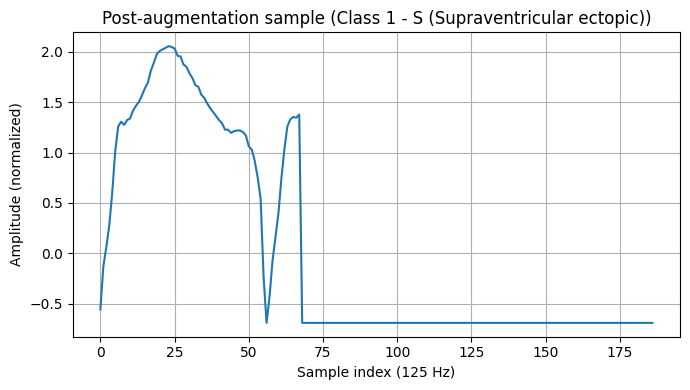

Saved: C:\Users\nikhi\Music\ECG\figures\augmented_example_c1_56528.png


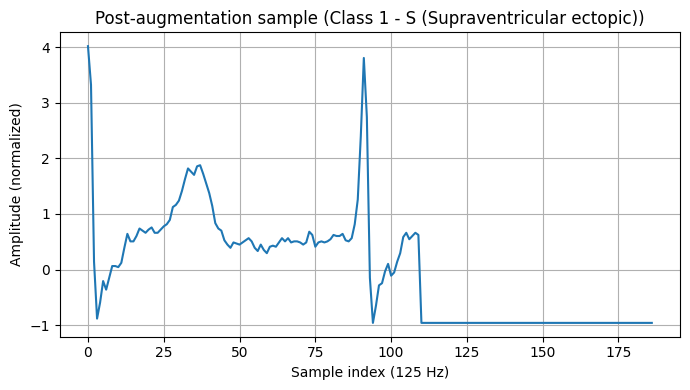

Saved: C:\Users\nikhi\Music\ECG\figures\augmented_example_c1_13641.png


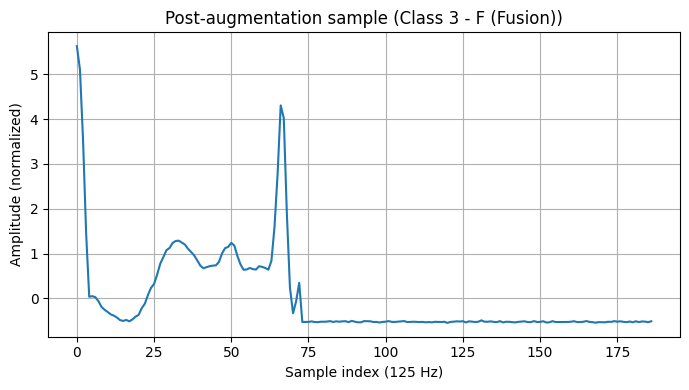

Saved: C:\Users\nikhi\Music\ECG\figures\augmented_example_c3_58684.png


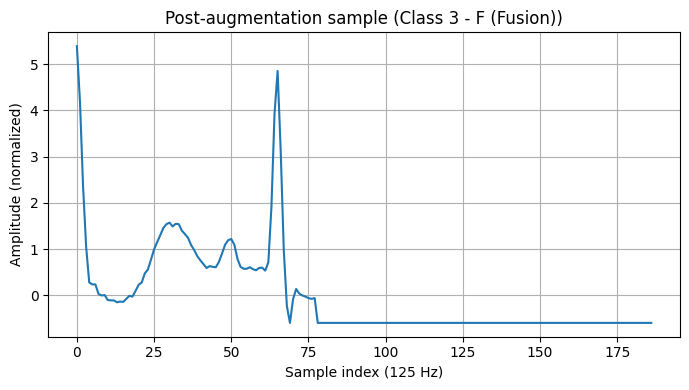

Saved: C:\Users\nikhi\Music\ECG\figures\augmented_example_c3_2701.png


In [19]:
# Cell 22: Sanity checks — counts & example augmented beats
import matplotlib.pyplot as plt

print_counts("Train (balanced)", y_tr_bal)
print_counts("Val   (normalized)", y_val_in)
print_counts("Test  (normalized)", y_te)

# Plot a few random augmented samples from minority classes
for c in [1,3]:  # S and F
    idxs = np.where(y_tr_bal == c)[0]
    if len(idxs) > 0:
        for i in np.random.RandomState(SEED).choice(idxs, size=min(2, len(idxs)), replace=False):
            plt.figure()
            plt.plot(X_tr_bal[i])
            plt.title(f"Post-augmentation sample (Class {c} - {class_map[c]})")
            plt.xlabel("Sample index (125 Hz)"); plt.ylabel("Amplitude (normalized)")
            plt.tight_layout()
            outp = FIGS / f"augmented_example_c{c}_{i}.png"
            plt.savefig(outp, dpi=150); plt.show()
            print("Saved:", outp)


In [20]:
# Cell 23: Save arrays — ML (2D) & DL (3D with channel=1)
# ML/Classic
np.save(PREP / "X_train_balanced_ml.npy", X_tr_bal)
np.save(PREP / "y_train_balanced.npy", y_tr_bal)

np.save(PREP / "X_val_ml.npy", X_val_n.astype(np.float32))
np.save(PREP / "y_val.npy", y_val_in.astype(int))

np.save(PREP / "X_test_ml.npy", X_te_n.astype(np.float32))
np.save(PREP / "y_test.npy", y_te.astype(int))

# DL/1D-CNN format (N, 187, 1)
X_train_dl = X_tr_bal[..., None]
X_val_dl = X_val_n[..., None]
X_test_dl = X_te_n[..., None]

np.save(PREP / "X_train_balanced_dl.npy", X_train_dl)
np.save(PREP / "X_val_dl.npy", X_val_dl)
np.save(PREP / "X_test_dl.npy", X_test_dl)

# Save normalization metadata & prep config
prep_meta = {
    "seed": SEED,
    "norm": norm_meta,
    "apply_butter": False,
    "apply_savgol": False,
    "targets": {int(k): int(v) for k, v in targets.items()},
    "class_weight": {int(k): float(v) for k,v in class_weight.items()},
    "shapes": {
        "X_train_ml": list(X_tr_bal.shape),
        "X_val_ml": list(X_val_n.shape),
        "X_test_ml": list(X_te_n.shape),
        "X_train_dl": list(X_train_dl.shape),
        "X_val_dl": list(X_val_dl.shape),
        "X_test_dl": list(X_test_dl.shape),
    }
}
with open(PREP / "prep_meta.json", "w") as f:
    json.dump(prep_meta, f, indent=2)

print("Saved ML arrays to:", PREP)
for p in ["X_train_balanced_ml.npy","y_train_balanced.npy","X_val_ml.npy","y_val.npy","X_test_ml.npy","y_test.npy",
          "X_train_balanced_dl.npy","X_val_dl.npy","X_test_dl.npy","prep_meta.json"]:
    print(" -", PREP / p)


Saved ML arrays to: C:\Users\nikhi\Music\ECG\prepared
 - C:\Users\nikhi\Music\ECG\prepared\X_train_balanced_ml.npy
 - C:\Users\nikhi\Music\ECG\prepared\y_train_balanced.npy
 - C:\Users\nikhi\Music\ECG\prepared\X_val_ml.npy
 - C:\Users\nikhi\Music\ECG\prepared\y_val.npy
 - C:\Users\nikhi\Music\ECG\prepared\X_test_ml.npy
 - C:\Users\nikhi\Music\ECG\prepared\y_test.npy
 - C:\Users\nikhi\Music\ECG\prepared\X_train_balanced_dl.npy
 - C:\Users\nikhi\Music\ECG\prepared\X_val_dl.npy
 - C:\Users\nikhi\Music\ECG\prepared\X_test_dl.npy
 - C:\Users\nikhi\Music\ECG\prepared\prep_meta.json


In [21]:
# Cell 24: OPTIONAL — SMOTE in PCA space (then inverse transform)
# Run if you want to compare ML baselines with SMOTE versus augmentation. OFF by default.

RUN_SMOTE_PCA = False  # toggle

if RUN_SMOTE_PCA:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from imblearn.over_sampling import SMOTE

    # Work on the normalized training set BEFORE our augmentations to simulate classical approach:
    X_base = X_tr_n
    y_base = y_tr_in

    # Scale features, reduce to 20 PCs
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_base)

    pca = PCA(n_components=20, random_state=SEED)
    Xp = pca.fit_transform(Xs)

    # SMOTE in PC space
    sm = SMOTE(random_state=SEED, k_neighbors=5)
    Xp_res, y_res = sm.fit_resample(Xp, y_base)

    # Inverse transform back to time-domain
    Xs_res = pca.inverse_transform(Xp_res)
    X_res = scaler.inverse_transform(Xs_res).astype(np.float32)

    # Save ONLY for ML experiments
    np.save(PREP / "X_train_smote_ml.npy", X_res)
    np.save(PREP / "y_train_smote.npy", y_res.astype(int))
    print_counts("Train (SMOTE-PCA) ML", y_res)
    print("Saved SMOTE-ML arrays at:", PREP)
else:
    print("SMOTE-PCA skipped. (Set RUN_SMOTE_PCA=True to run.)")


SMOTE-PCA skipped. (Set RUN_SMOTE_PCA=True to run.)


In [22]:
# Cell 25: Final distribution tables (CSV) for report
def dist_table(y, name):
    d = class_counts_np(y)
    df = pd.DataFrame({"class_idx": list(d.keys()), "count": list(d.values())})
    df["class"] = df["class_idx"].map({i: ["N","S","V","F","Q"][i] for i in range(5)})
    outp = RESULTS / f"dist_{name}.csv"
    df.to_csv(outp, index=False)
    print("Saved:", outp)
    return df

display(dist_table(y_tr_in, "train_raw"))
display(dist_table(y_tr_bal, "train_balanced"))
display(dist_table(y_val_in, "val"))
display(dist_table(y_te, "test"))


Saved: C:\Users\nikhi\Music\ECG\results\dist_train_raw.csv


,class_idx,count,class
0,0,65223,N
1,1,2001,S
2,2,5209,V
3,3,577,F
4,4,5788,Q


Saved: C:\Users\nikhi\Music\ECG\results\dist_train_balanced.csv


,class_idx,count,class
0,0,65223,N
1,1,2001,S
2,2,5209,V
3,3,1811,F
4,4,5788,Q


Saved: C:\Users\nikhi\Music\ECG\results\dist_val.csv


,class_idx,count,class
0,0,7248,N
1,1,222,S
2,2,579,V
3,3,64,F
4,4,643,Q


Saved: C:\Users\nikhi\Music\ECG\results\dist_test.csv


,class_idx,count,class
0,0,18118,N
1,1,556,S
2,2,1448,V
3,3,162,F
4,4,1608,Q


In [23]:
# Cell 30: Load arrays and set up metrics/plots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_recall_curve, average_precision_score,
                             roc_auc_score)
from pathlib import Path

# Load prepared arrays (from Phase 2 or Cell 28 A/B selection)
X_train = np.load(PREP / "X_train_balanced_ml.npy")
y_train = np.load(PREP / "y_train_balanced.npy")
X_val   = np.load(PREP / "X_val_ml.npy")
y_val   = np.load(PREP / "y_val.npy")
X_test  = np.load(PREP / "X_test_ml.npy")
y_test  = np.load(PREP / "y_test.npy")

print(X_train.shape, y_train.shape, "| val:", X_val.shape, y_val.shape, "| test:", X_test.shape, y_test.shape)

class_names = ["N","S","V","F","Q"]

def evaluate_model(model, X, y, set_name="val", average="macro"):
    pred = model.predict(X)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
    else:
        # SVM decision_function -> convert to softmax-like probabilities
        try:
            from sklearn.preprocessing import MinMaxScaler
            df = model.decision_function(X)
            if df.ndim == 1:  # binary
                df = np.vstack([-df, df]).T
            proba = MinMaxScaler().fit_transform(df)
        except:
            proba = None

    f1m = f1_score(y, pred, average=average)
    print(f"[{set_name}] macro-F1: {f1m:.4f}")
    print(classification_report(y, pred, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y, pred, labels=[0,1,2,3,4])
    plt.figure(figsize=(6,5))
    plt.imshow(cm, aspect='auto')
    plt.title(f"Confusion Matrix ({set_name})")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(5), class_names); plt.yticks(range(5), class_names)
    plt.colorbar(); plt.tight_layout()
    outp = FIGS / f"cm_{set_name}_{model.__class__.__name__}.png"
    plt.savefig(outp, dpi=150); plt.show()
    print("Saved:", outp)

    # PR-AUC / ROC-AUC (OvR)
    if proba is not None:
        ap_macro = average_precision_score(y, proba, average="macro")
        try:
            roc_macro = roc_auc_score(y, proba, multi_class="ovr", average="macro")
        except Exception:
            roc_macro = np.nan
        print(f"[{set_name}] PR-AUC(macro): {ap_macro:.4f} | ROC-AUC(macro): {roc_macro:.4f}")

        # PR curves per class
        for c in range(5):
            y_bin = (y == c).astype(int)
            prec, rec, _ = precision_recall_curve(y_bin, proba[:, c])
            plt.figure(figsize=(6,4))
            plt.plot(rec, prec)
            plt.title(f"PR Curve ({set_name}) — class {c}:{class_names[c]}")
            plt.xlabel("Recall"); plt.ylabel("Precision"); plt.tight_layout()
            outp = FIGS / f"pr_{set_name}_{model.__class__.__name__}_c{c}.png"
            plt.savefig(outp, dpi=150); plt.show()
    return f1m


(80032, 187) (80032,) | val: (8756, 187) (8756,) | test: (21892, 187) (21892,)


In [24]:
# Cell 31: Load class weights for models that support it
import json

with open(PREP / "class_weight.json") as f:
    class_weight = {int(k): float(v) for k, v in json.load(f).items()}

class_weight_bal = "balanced"  # for scikit models that accept this string
print("Class weights (from Phase 2):", class_weight)


Class weights (from Phase 2): {0: 0.24541036137558836, 1: 7.9992003998001, 2: 3.0728354770589363, 3: 8.838431805632247, 4: 2.765445749827229}


[val] macro-F1: 0.4910
              precision    recall  f1-score   support

           N     0.9778    0.6558    0.7850      7248
           S     0.1605    0.6847    0.2601       222
           V     0.2810    0.7547    0.4096       579
           F     0.1020    0.8750    0.1827        64
           Q     0.7204    0.9456    0.8178       643

    accuracy                         0.6859      8756
   macro avg     0.4483    0.7832    0.4910      8756
weighted avg     0.8857    0.6859    0.7449      8756



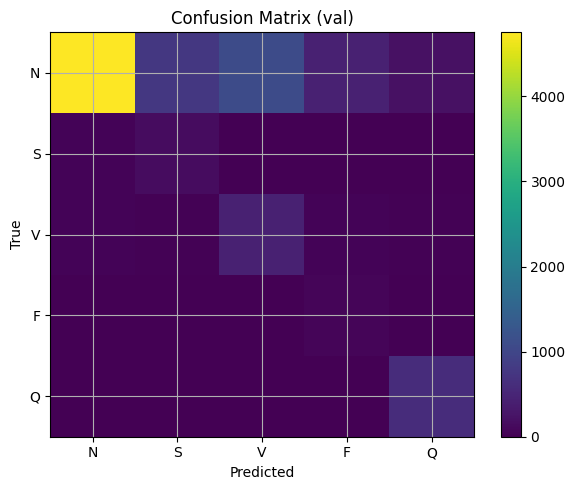

Saved: C:\Users\nikhi\Music\ECG\figures\cm_val_LogisticRegression.png
[val] PR-AUC(macro): 0.6001 | ROC-AUC(macro): 0.9207


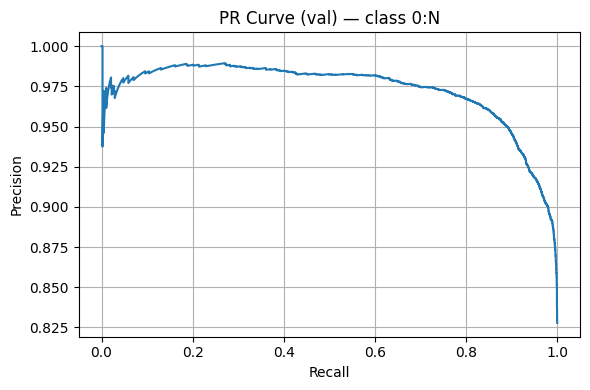

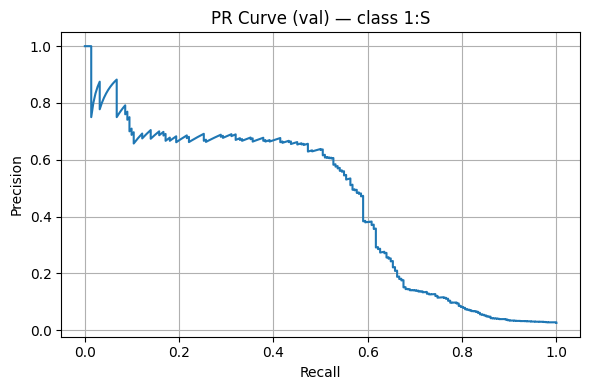

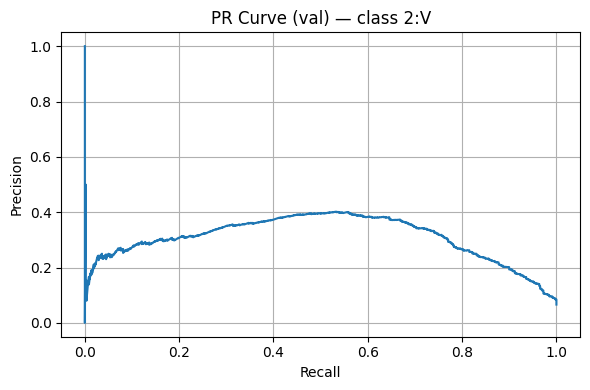

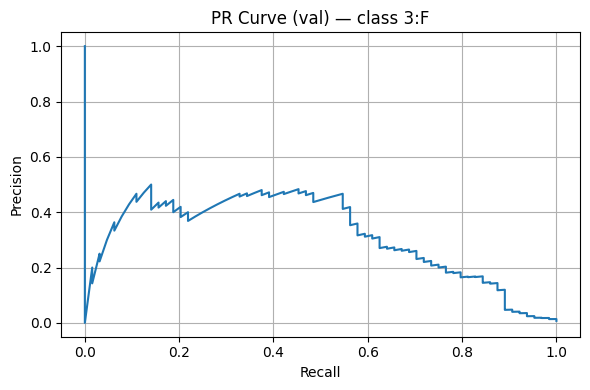

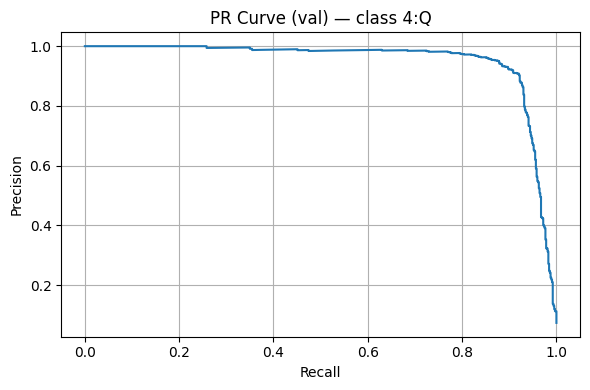

Val macro-F1 (LogReg): 0.4910217245171439


In [25]:
# Cell 32: Logistic Regression (OvR)
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=2000, class_weight=class_weight_bal, n_jobs=-1)
logreg.fit(X_train, y_train)

f1_val_lr = evaluate_model(logreg, X_val, y_val, set_name="val")
print("Val macro-F1 (LogReg):", f1_val_lr)


In [26]:
# New Cell: Build a fast SVM tuning subset (and optional PCA)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Make a stratified subset ~12k samples (adjust if you want)
TUNE_SIZE = 12000  # 8k–15k is a good range for RBF SVM
sss = StratifiedShuffleSplit(n_splits=1, train_size=TUNE_SIZE, random_state=SEED)
idx_sub = next(sss.split(X_train, y_train))[0]

X_train_svm_tune = X_train[idx_sub]
y_train_svm_tune = y_train[idx_sub]

print("SVM tuning subset:", X_train_svm_tune.shape, dict(zip(*np.unique(y_train_svm_tune, return_counts=True))))

# 2) Standardize (important for SVM)
scaler_svm = StandardScaler().fit(X_train_svm_tune)
X_train_svm_tune = scaler_svm.transform(X_train_svm_tune)
X_val_svm = scaler_svm.transform(X_val)  # transform val with same scaler

# 3) Optional: PCA to 40 dims for extra speed (keeps most variance)
USE_PCA_FOR_SVM = True
if USE_PCA_FOR_SVM:
    pca_svm = PCA(n_components=40, random_state=SEED)
    X_train_svm_tune = pca_svm.fit_transform(X_train_svm_tune)
    X_val_svm = pca_svm.transform(X_val)
    print("SVM tuning dims after PCA:", X_train_svm_tune.shape[1])
else:
    pca_svm = None


SVM tuning subset: (12000, 187) {np.int64(0): np.int64(9779), np.int64(1): np.int64(300), np.int64(2): np.int64(781), np.int64(3): np.int64(272), np.int64(4): np.int64(868)}
SVM tuning dims after PCA: 40


[I 2025-10-24 00:00:18,119] A new study created in RDB with name: svm_rbf_val_macroF1


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-24 00:00:46,648] Trial 0 finished with value: 0.5337097208666353 and parameters: {'C': 0.33045662495310263, 'gamma': 0.001760440029957206}. Best is trial 0 with value: 0.5337097208666353.
[I 2025-10-24 00:01:09,802] Trial 1 finished with value: 0.2742560214788752 and parameters: {'C': 0.36781433571192107, 'gamma': 0.0421843718479744}. Best is trial 0 with value: 0.5337097208666353.
[I 2025-10-24 00:01:43,544] Trial 2 finished with value: 0.18115471132216945 and parameters: {'C': 0.10699625114877719, 'gamma': 0.5563381670723276}. Best is trial 0 with value: 0.5337097208666353.
[I 2025-10-24 00:02:17,682] Trial 3 finished with value: 0.18115471132216945 and parameters: {'C': 0.15067960277487766, 'gamma': 0.3140409935668662}. Best is trial 0 with value: 0.5337097208666353.
[I 2025-10-24 00:02:31,204] Trial 4 finished with value: 0.5102014488131262 and parameters: {'C': 1.446254788161978, 'gamma': 0.0008776119493171415}. Best is trial 0 with value: 0.5337097208666353.
[I 2025-10

C:\Users\nikhi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nikhi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nikhi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

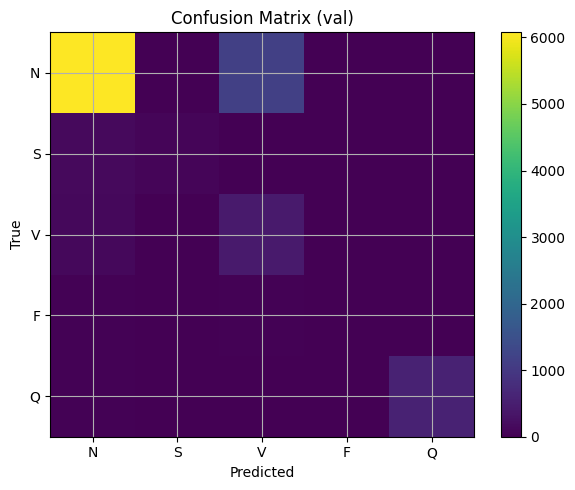

Saved: C:\Users\nikhi\Music\ECG\figures\cm_val_SVC_SVMsubset.png


In [27]:
# Cell 33 (fast & resumable): SVM RBF + Optuna on the subset
import optuna
from optuna.pruners import MedianPruner
from sklearn.svm import SVC
from sklearn.metrics import f1_score

N_TRIALS   = 20             # you can lower to 12–15 if needed
TIMEOUT_S  = 600            # 10 minutes; set None if you prefer trials count
STUDY_NAME = "svm_rbf_val_macroF1"
STORAGE    = f"sqlite:///{(RESULTS / 'optuna_svm.db').as_posix()}"

def objective_svm(trial):
    C     = trial.suggest_float("C", 0.1, 20.0, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)
    clf = SVC(
        C=C, gamma=gamma, kernel="rbf",
        class_weight="balanced", probability=False, random_state=SEED,
        cache_size=1000, shrinking=True
    )
    clf.fit(X_train_svm_tune, y_train_svm_tune)
    pred = clf.predict(X_val_svm)
    return f1_score(y_val, pred, average="macro")

study_svm = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=STORAGE,
    load_if_exists=True,
    pruner=MedianPruner(n_warmup_steps=5),
)
study_svm.optimize(objective_svm, n_trials=N_TRIALS, timeout=TIMEOUT_S, show_progress_bar=True)

print("Best SVM params:", study_svm.best_params, "best_macroF1:", study_svm.best_value)

# Train final SVM on the same *tuning pipeline* (subset + scaler/PCA) for fair val comparison
svm_best = SVC(**study_svm.best_params, kernel="rbf", class_weight="balanced",
               probability=False, random_state=SEED, cache_size=1000, shrinking=True)
svm_best.fit(X_train_svm_tune, y_train_svm_tune)

# Use the evaluator from Cell 30; it will handle decision_function when no predict_proba
# IMPORTANT: pass the PCA/scaled validation arrays
# We'll temporarily wrap evaluate_model to accept pre-transformed inputs
def evaluate_model_preX(model, X_pre, y, set_name="val"):
    # mimic evaluate_model but skip internal transforms
    from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                                 precision_recall_curve, average_precision_score, roc_auc_score)
    pred = model.predict(X_pre)
    f1m = f1_score(y, pred, average="macro")
    print(f"[{set_name}] macro-F1: {f1m:.4f}")
    print(classification_report(y, pred, target_names=["N","S","V","F","Q"], digits=4))

    cm = confusion_matrix(y, pred, labels=[0,1,2,3,4])
    plt.figure(figsize=(6,5))
    plt.imshow(cm, aspect='auto')
    plt.title(f"Confusion Matrix ({set_name})")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(5), ["N","S","V","F","Q"]); plt.yticks(range(5), ["N","S","V","F","Q"])
    plt.colorbar(); plt.tight_layout()
    outp = FIGS / f"cm_{set_name}_{model.__class__.__name__}_SVMsubset.png"
    plt.savefig(outp, dpi=150); plt.show()
    print("Saved:", outp)
    return f1m

f1_val_svm = evaluate_model_preX(svm_best, X_val_svm, y_val, set_name="val")


In [29]:
# New: RF tuning subset (+ sub-sampling per tree support)

from sklearn.model_selection import StratifiedShuffleSplit

# Use a stratified subset for speed; 20–40k is good. Tune if you want.
RF_TUNE_SIZE = 30000
sss = StratifiedShuffleSplit(n_splits=1, train_size=RF_TUNE_SIZE, random_state=SEED)
idx_sub = next(sss.split(X_train, y_train))[0]

X_train_rf_tune = X_train[idx_sub]
y_train_rf_tune = y_train[idx_sub]

print("RF tuning subset:", X_train_rf_tune.shape,
      dict(zip(*np.unique(y_train_rf_tune, return_counts=True))))


RF tuning subset: (30000, 187) {np.int64(0): np.int64(24449), np.int64(1): np.int64(750), np.int64(2): np.int64(1952), np.int64(3): np.int64(679), np.int64(4): np.int64(2170)}


[I 2025-10-24 00:46:15,086] A new study created in RDB with name: rf_macroF1_subset


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-24 00:46:37,204] Trial 0 finished with value: 0.8155852253895943 and parameters: {'n_estimators': 400, 'max_depth': 16, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_samples': 0.7656194179800357}. Best is trial 0 with value: 0.8155852253895943.
[I 2025-10-24 00:53:21,260] Trial 1 finished with value: 0.8445211475843946 and parameters: {'n_estimators': 600, 'max_depth': 20, 'max_features': 0.4, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8224442916995662}. Best is trial 1 with value: 0.8445211475843946.
[I 2025-10-24 00:54:31,116] Trial 2 finished with value: 0.8198095367563203 and parameters: {'n_estimators': 700, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_samples': 0.8382333285343226}. Best is trial 1 with value: 0.8445211475843946.
[I 2025-10-24 01:04:07,633] Trial 3 finished with value: 0.8247233121731146 and parameters: {'n_estimators': 300, 'max_depth': 14, 'max_features

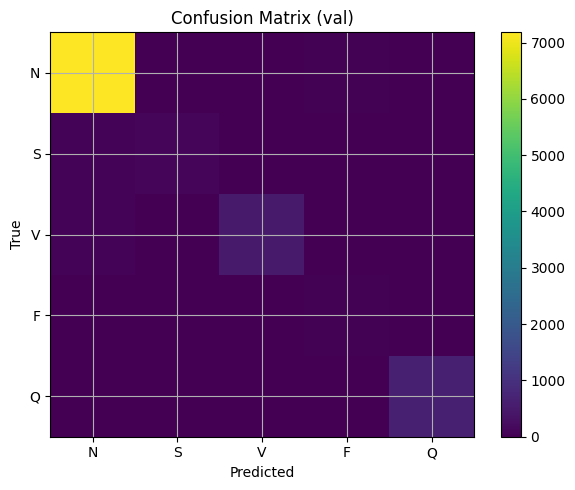

Saved: C:\Users\nikhi\Music\ECG\figures\cm_val_RandomForestClassifier.png
[val] PR-AUC(macro): 0.9048 | ROC-AUC(macro): 0.9917


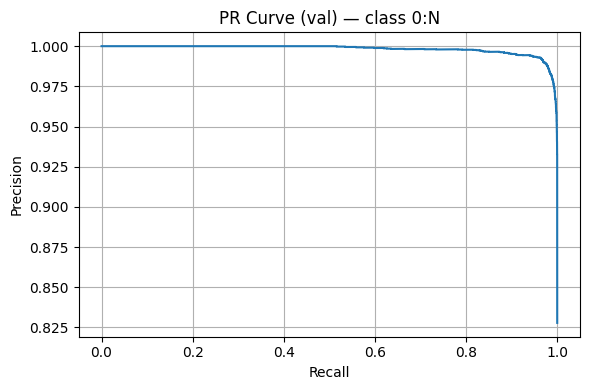

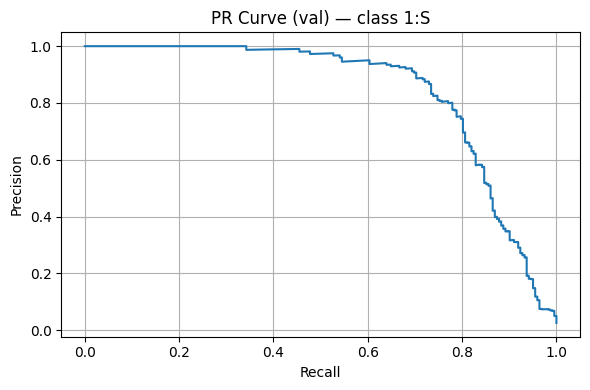

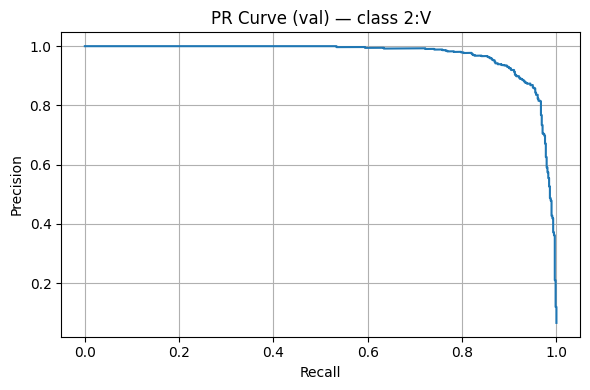

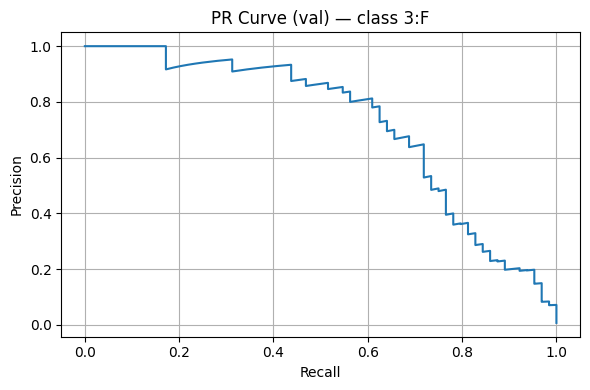

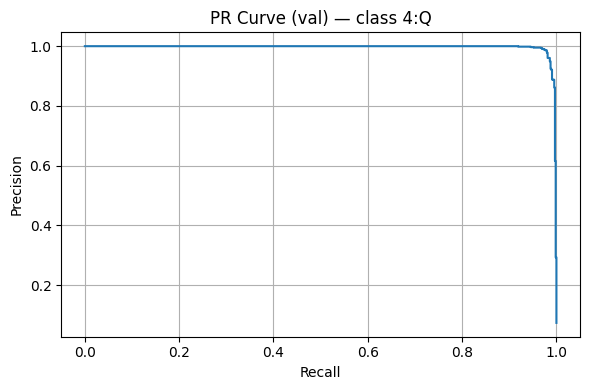

Validation macro-F1 (RF): 0.8445211475843946


In [30]:
# Cell 34 (FAST & RESUMABLE): RandomForest + Optuna (subset + tree subsampling)

import optuna
from optuna.pruners import MedianPruner
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np

N_TRIALS   = 20            # you can cut to 12–15 if pressed for time
TIMEOUT_S  = 900           # 15 minutes budget; set None to use N_TRIALS only
STUDY_NAME = "rf_macroF1_subset"
STORAGE    = f"sqlite:///{(RESULTS / 'optuna_rf.db').as_posix()}"

def objective_rf(trial):
    # Subsample trees to speed up: bootstrap=True + max_samples (fraction)
    n_estimators     = trial.suggest_int("n_estimators", 300, 700, step=100)
    max_depth        = trial.suggest_int("max_depth", 10, 22, step=2)
    max_features     = trial.suggest_categorical("max_features", ["sqrt", "log2", 0.4])
    min_samples_split= trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    max_samples_frac = trial.suggest_float("max_samples", 0.5, 0.9)  # per-tree subsample

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced_subsample",
        bootstrap=True,
        max_samples=max_samples_frac,  # <— speeds up a lot
        n_jobs=-1,
        random_state=SEED
    )
    clf.fit(X_train_rf_tune, y_train_rf_tune)
    pred = clf.predict(X_val)
    return f1_score(y_val, pred, average="macro")

study_rf = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=STORAGE,
    load_if_exists=True,
    pruner=MedianPruner(n_warmup_steps=5),
)
study_rf.optimize(objective_rf, n_trials=N_TRIALS, timeout=TIMEOUT_S, show_progress_bar=True)

print("Best RF params (subset):", study_rf.best_params, "best_macroF1:", study_rf.best_value)

# Train final RF — choose whether to fit on FULL data or subset (full can take longer).
FIT_FULL_AFTER_TUNING = False   # set True if you want the absolute best and don’t mind extra time

best_params = study_rf.best_params.copy()
rf_best = RandomForestClassifier(
    **best_params,
    class_weight="balanced_subsample",
    bootstrap=True,
    n_jobs=-1,
    random_state=SEED
)

if FIT_FULL_AFTER_TUNING:
    # When fitting full, keep max_samples as a fraction to retain speed
    rf_best.fit(X_train, y_train)
    f1_val_rf = evaluate_model(rf_best, X_val, y_val, set_name="val")
else:
    rf_best.fit(X_train_rf_tune, y_train_rf_tune)
    f1_val_rf = evaluate_model(rf_best, X_val, y_val, set_name="val")

print("Validation macro-F1 (RF):", f1_val_rf)


XGBoost version: 3.0.4
XGB tuning subset: (50000, 187) {np.int64(0): np.int64(40748), np.int64(1): np.int64(1250), np.int64(2): np.int64(3254), np.int64(3): np.int64(1132), np.int64(4): np.int64(3616)}


[I 2025-10-24 01:52:00,613] Using an existing study with name 'xgb_macroF1_subset' instead of creating a new one.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-24 01:54:22,129] Trial 3 finished with value: 0.8825344236976942 and parameters: {'learning_rate': 0.12840634116311422, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.9264963039249394, 'colsample_bytree': 0.7846414977889201, 'lambda': 0.11524977403890403, 'alpha': 0.9664852797307445, 'n_estimators': 400}. Best is trial 3 with value: 0.8825344236976942.
[I 2025-10-24 01:58:13,425] Trial 4 finished with value: 0.9047828461747942 and parameters: {'learning_rate': 0.19131963787581488, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8161479945083363, 'colsample_bytree': 0.5464961172122864, 'lambda': 0.07823912891426484, 'alpha': 4.285670106647695, 'n_estimators': 700}. Best is trial 4 with value: 0.9047828461747942.
[I 2025-10-24 02:07:47,455] Trial 5 finished with value: 0.9128860481489024 and parameters: {'learning_rate': 0.03626426886319798, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9988811289180641, 'colsample_bytree': 0.5190678209917474, 'lambda': 0

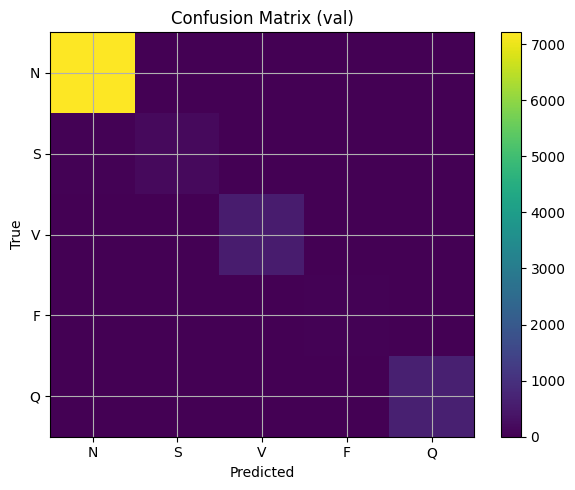

Saved: C:\Users\nikhi\Music\ECG\figures\cm_val_XGBClassifier.png
[val] PR-AUC(macro): 0.9433 | ROC-AUC(macro): 0.9948


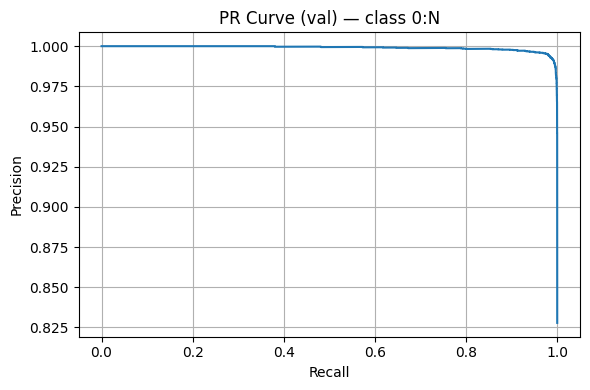

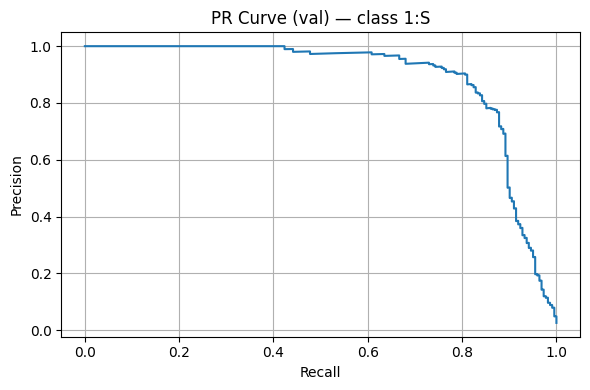

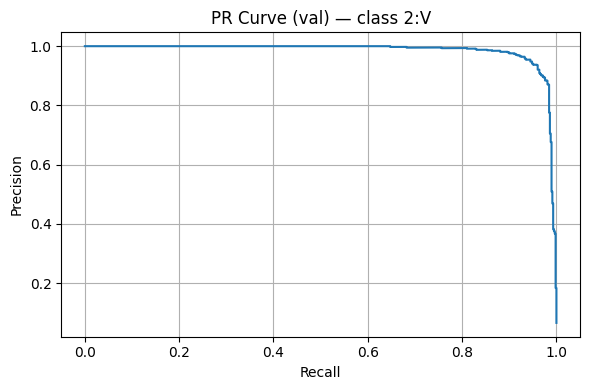

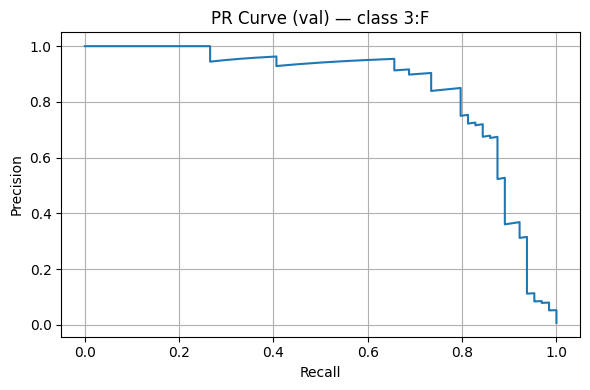

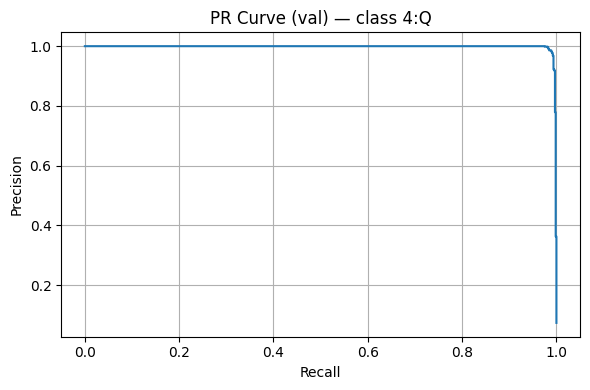

In [35]:
# Cell 35 (Version-proof, FAST & RESUMABLE): XGBoost + Optuna on subset
import optuna
from optuna.pruners import MedianPruner
import xgboost as xgb
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score

print("XGBoost version:", xgb.__version__)

# --------- stratified tuning subset ----------
XGB_TUNE_SIZE = 50000
sss = StratifiedShuffleSplit(n_splits=1, train_size=XGB_TUNE_SIZE, random_state=SEED)
idx_sub = next(sss.split(X_train, y_train))[0]
X_train_xgb_tune = X_train[idx_sub]
y_train_xgb_tune = y_train[idx_sub]
print("XGB tuning subset:", X_train_xgb_tune.shape,
      dict(zip(*np.unique(y_train_xgb_tune, return_counts=True))))

# class-imbalance weights
w_train_xgb_tune = np.vectorize(class_weight.get)(y_train_xgb_tune)

# --------- Optuna config ----------
N_TRIALS   = 20            # adjust for time
TIMEOUT_S  = 900           # 15 min budget; set None to ignore
STUDY_NAME = "xgb_macroF1_subset"
STORAGE    = f"sqlite:///{(RESULTS / 'optuna_xgb.db').as_posix()}"

def objective_xgb(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": 5,
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.25, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
    }
    n_estimators = trial.suggest_int("n_estimators", 300, 900, step=100)

    clf = xgb.XGBClassifier(
        **params, n_estimators=n_estimators, random_state=SEED, n_jobs=-1
    )

    # Try early stopping via callbacks; if unsupported, fall back to plain fit
    try:
        es = xgb.callback.EarlyStopping(rounds=50, save_best=True, maximize=False)
        clf.fit(
            X_train_xgb_tune, y_train_xgb_tune,
            sample_weight=w_train_xgb_tune,
            eval_set=[(X_val, y_val)],
            callbacks=[es],
            verbose=False
        )
    except TypeError:
        # Older wrappers may not accept callbacks; do a simple fit instead
        clf.fit(
            X_train_xgb_tune, y_train_xgb_tune,
            sample_weight=w_train_xgb_tune,
            verbose=False
        )

    pred = clf.predict(X_val)
    return f1_score(y_val, pred, average="macro")

study_xgb = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=STORAGE,
    load_if_exists=True,
    pruner=MedianPruner(n_warmup_steps=5),
)
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS, timeout=TIMEOUT_S, show_progress_bar=True)

print("Best XGB params (subset):", study_xgb.best_params, "best_macroF1:", study_xgb.best_value)

# --------- Final model (subset or full) ----------
FIT_FULL_AFTER_TUNING = False   # set True if you want maximum accuracy (longer)

best_params = study_xgb.best_params.copy()
xgb_best = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",
    tree_method="hist",
    **best_params,
    random_state=SEED,
    n_jobs=-1
)

try:
    es = xgb.callback.EarlyStopping(rounds=50, save_best=True, maximize=False)
    if FIT_FULL_AFTER_TUNING:
        w_train_full = np.vectorize(class_weight.get)(y_train)
        xgb_best.fit(
            X_train, y_train,
            sample_weight=w_train_full,
            eval_set=[(X_val, y_val)],
            callbacks=[es],
            verbose=False
        )
    else:
        xgb_best.fit(
            X_train_xgb_tune, y_train_xgb_tune,
            sample_weight=w_train_xgb_tune,
            eval_set=[(X_val, y_val)],
            callbacks=[es],
            verbose=False
        )
except TypeError:
    # Fallback: no early stopping
    if FIT_FULL_AFTER_TUNING:
        w_train_full = np.vectorize(class_weight.get)(y_train)
        xgb_best.fit(X_train, y_train, sample_weight=w_train_full, verbose=False)
    else:
        xgb_best.fit(X_train_xgb_tune, y_train_xgb_tune, sample_weight=w_train_xgb_tune, verbose=False)

# Evaluate on validation (existing helper from Cell 30)
f1_val_xgb = evaluate_model(xgb_best, X_val, y_val, set_name="val")


In [38]:
# Validation leaderboard (robust) & choose best

import pandas as pd
import numpy as np

# Collect available models & their validation macro-F1 scores
available = []

if 'f1_val_lr' in globals() and 'logreg' in globals():
    available.append(("LogReg", float(f1_val_lr), logreg))

if 'f1_val_svm' in globals() and 'svm_best' in globals():
    available.append(("SVM-RBF", float(f1_val_svm), svm_best))

if 'f1_val_rf' in globals() and 'rf_best' in globals():
    available.append(("RandomForest", float(f1_val_rf), rf_best))

if 'f1_val_xgb' in globals() and 'xgb_best' in globals():
    available.append(("XGBoost", float(f1_val_xgb), xgb_best))

assert len(available) > 0, "No models found. Run Cells 32–35 first."

leaderboard = pd.DataFrame(
    [{"model": name, "val_macro_f1": score} for (name, score, mdl) in available]
).sort_values("val_macro_f1", ascending=False, ignore_index=True)

display(leaderboard)

best_name = leaderboard.iloc[0]["model"]
best_score = float(leaderboard.iloc[0]["val_macro_f1"])
best_model = {name: mdl for (name, _, mdl) in available}[best_name]

print(f"Best on validation: {best_name} (macro-F1={best_score:.4f})")

# Save leaderboard
leaderboard.to_csv(RESULTS / "val_leaderboard.csv", index=False)
print("Saved:", RESULTS / "val_leaderboard.csv")


,model,val_macro_f1
0,XGBoost,0.912886
1,RandomForest,0.844521
2,SVM-RBF,0.535145
3,LogReg,0.491022


Best on validation: XGBoost (macro-F1=0.9129)
Saved: C:\Users\nikhi\Music\ECG\results\val_leaderboard.csv


Calibrating best model: XGBoost
[val_calibrated] macro-F1: 0.9106
              precision    recall  f1-score   support

           N     0.9884    0.9950    0.9917      7248
           S     0.9185    0.7613    0.8325       222
           V     0.9510    0.9396    0.9453       579
           F     0.8305    0.7656    0.7967        64
           Q     0.9860    0.9876    0.9868       643

    accuracy                         0.9832      8756
   macro avg     0.9349    0.8898    0.9106      8756
weighted avg     0.9828    0.9832    0.9828      8756



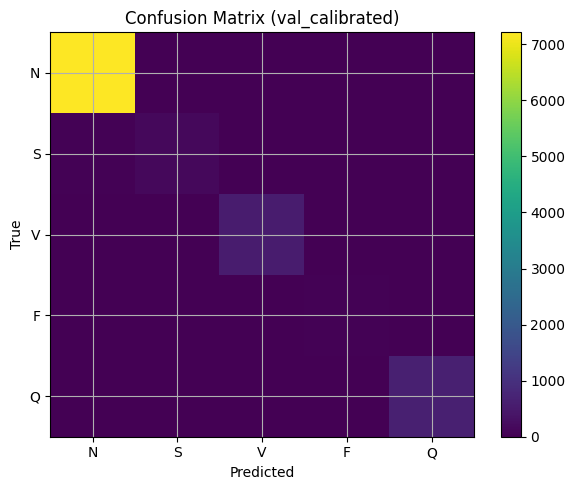

Saved: C:\Users\nikhi\Music\ECG\figures\cm_val_calibrated_CalibratedClassifierCV.png
[val_calibrated] PR-AUC(macro): 0.9505 | ROC-AUC(macro): 0.9968


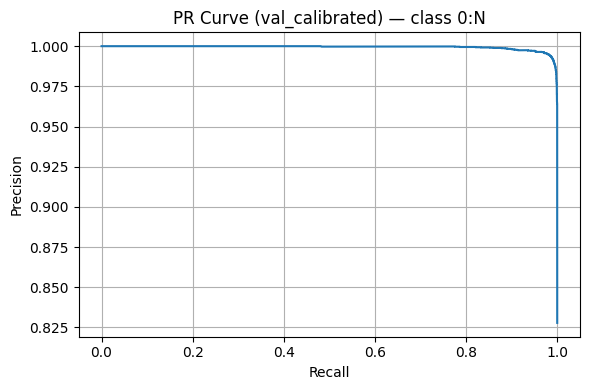

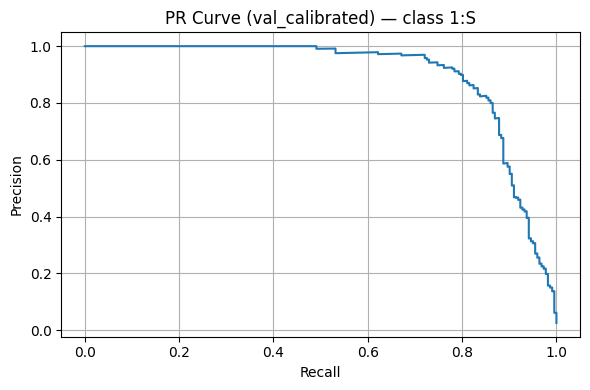

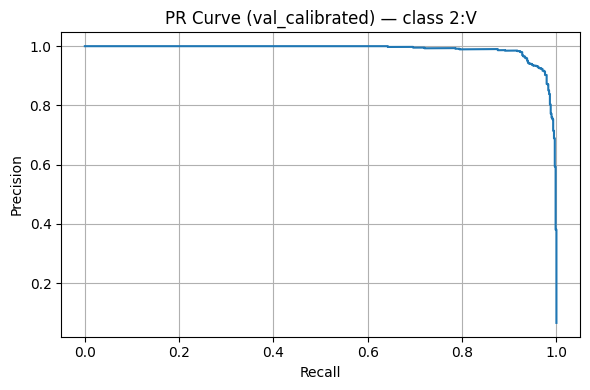

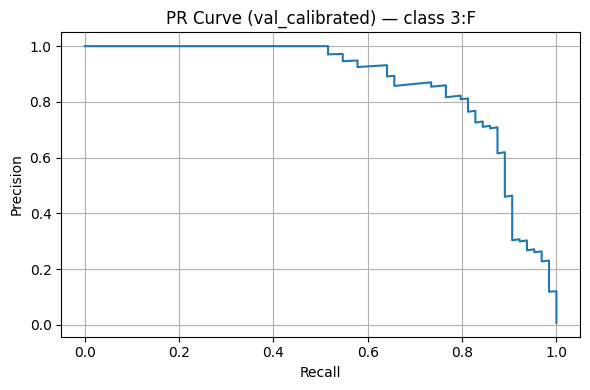

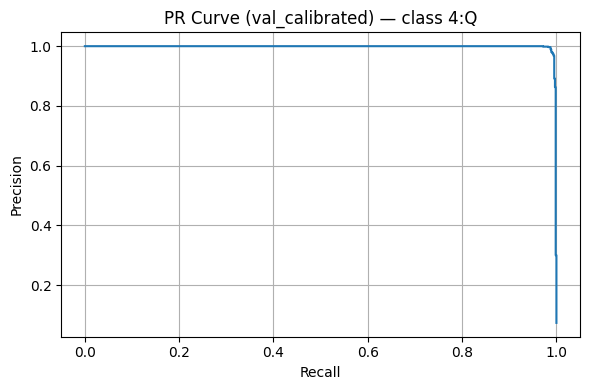

Val macro-F1 (calibrated): 0.910599449308078
Saved calibrated model: C:\Users\nikhi\Music\ECG\models\XGBoost_calibrated_phase3.pkl


In [39]:
# Cell 35B (updated): Probability calibration (isotonic) for the current best model

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from copy import deepcopy
from pathlib import Path
import joblib

assert 'best_model' in globals(), "Run the Validation Leaderboard cell first to set `best_model`."
assert 'best_name'  in globals(), "Run the Validation Leaderboard cell first to set `best_name`."

print(f"Calibrating best model: {best_name}")

# Use a fresh copy to avoid altering the original trained instance
base_for_cal = deepcopy(best_model)

# Fit isotonic calibration on TRAIN (3-fold CV internally)
calibrated_model = CalibratedClassifierCV(base_for_cal, method='isotonic', cv=3)
calibrated_model.fit(X_train, y_train)

# Evaluate on validation (uses evaluate_model from Cell 30)
f1_val_cal = evaluate_model(calibrated_model, X_val, y_val, set_name="val_calibrated")
print("Val macro-F1 (calibrated):", f1_val_cal)

# (Optional) Save calibrated model artifact for later use
Path(PROJ / "models").mkdir(exist_ok=True)
cal_path = PROJ / "models" / f"{best_name}_calibrated_phase3.pkl"
joblib.dump(calibrated_model, cal_path)
print("Saved calibrated model:", cal_path)


In [40]:
# Cell 35C (updated): Per-class threshold tuning on validation

import numpy as np
import pandas as pd
import json
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# 1) Pick model to threshold
use_model = calibrated_model if 'calibrated_model' in globals() else best_model
model_name = f"{best_name}{'_cal' if 'calibrated_model' in globals() else ''}"
print(f"Threshold tuning on: {model_name}")

# 2) Get calibrated probabilities on VAL
if not hasattr(use_model, "predict_proba"):
    raise RuntimeError("Model must support predict_proba. Calibrate first (Cell 35B).")
proba_val = use_model.predict_proba(X_val)

# 3) Baseline (argmax) macro-F1
y_val_argmax = proba_val.argmax(axis=1)
baseline_macro = f1_score(y_val, y_val_argmax, average="macro")
print(f"Val macro-F1 (argmax baseline): {baseline_macro:.4f}")

# 4) Search per-class thresholds (maximize 1-vs-rest F1 per class)
grid = np.linspace(0.10, 0.90, 33)  # coarse grid; fast & effective
thresholds = np.full(5, 0.50, dtype=float)
per_class_best = []

for c in range(5):
    y_true_bin = (y_val == c).astype(int)
    ps = proba_val[:, c]
    best_t, best_f1 = 0.50, 0.0
    for t in grid:
        y_hat_bin = (ps >= t).astype(int)
        f1c = f1_score(y_true_bin, y_hat_bin, zero_division=0)
        if f1c > best_f1:
            best_f1, best_t = f1c, t
    thresholds[c] = best_t
    per_class_best.append((c, best_t, best_f1))

print("Per-class thresholds:", thresholds.round(3))

def predict_with_thresholds(proba: np.ndarray, thr: np.ndarray) -> np.ndarray:
    # Start with argmax; override with any class that crosses its own threshold (choose highest proba among hits)
    arg = proba.argmax(axis=1)
    y_pred = arg.copy()
    for i in range(proba.shape[0]):
        hits = np.where(proba[i] >= thr)[0]
        if len(hits) == 1:
            y_pred[i] = hits[0]
        elif len(hits) > 1:
            y_pred[i] = hits[np.argmax(proba[i, hits])]
    return y_pred

# 5) Evaluate thresholded predictions
y_val_thr = predict_with_thresholds(proba_val, thresholds)
macro_thr = f1_score(y_val, y_val_thr, average="macro")
print(f"Val macro-F1 (thresholded): {macro_thr:.4f}")

# 6) Detailed per-class F1 before vs after (nice for reports/interviews)
def per_class_f1(y_true, y_pred):
    return pd.Series(
        [f1_score((y_true==c).astype(int), (y_pred==c).astype(int), zero_division=0) for c in range(5)],
        index=["N","S","V","F","Q"]
    )

f1_argmax = per_class_f1(y_val, y_val_argmax)
f1_thr    = per_class_f1(y_val, y_val_thr)

comp_df = pd.DataFrame({
    "F1_argmax": f1_argmax.round(4),
    "F1_thresholded": f1_thr.round(4)
})
comp_df["delta"] = (comp_df["F1_thresholded"] - comp_df["F1_argmax"]).round(4)
display(comp_df)

# 7) Save thresholds & comparison tables
thr_json = {
    "model": model_name,
    "thresholds": thresholds.tolist(),
    "macro_f1_argmax": float(baseline_macro),
    "macro_f1_thresholded": float(macro_thr),
    "per_class_1vsRest_best": [
        {"class": int(c), "threshold": float(t), "f1_1vsRest": float(f)} for (c,t,f) in per_class_best
    ],
}
with open(RESULTS / "per_class_thresholds.json", "w") as f:
    json.dump(thr_json, f, indent=2)

comp_df.to_csv(RESULTS / "per_class_f1_before_after.csv")
print("Saved:", RESULTS / "per_class_thresholds.json")
print("Saved:", RESULTS / "per_class_f1_before_after.csv")


Threshold tuning on: XGBoost_cal
Val macro-F1 (argmax baseline): 0.9106
Per-class thresholds: [0.45  0.475 0.675 0.325 0.6  ]
Val macro-F1 (thresholded): 0.9148


,F1_argmax,F1_thresholded,delta
N,0.9917,0.9917,0.0000
S,0.8325,0.8325,0.0000
V,0.9453,0.9469,0.0016
F,0.7967,0.8160,0.0193
Q,0.9868,0.9868,0.0000


Saved: C:\Users\nikhi\Music\ECG\results\per_class_thresholds.json
Saved: C:\Users\nikhi\Music\ECG\results\per_class_f1_before_after.csv


Error analysis using: XGBoost_cal
Saved full error summary: C:\Users\nikhi\Music\ECG\results\error_summary.csv

Class 1:S — worst FN count=6
Saved: C:\Users\nikhi\Music\ECG\results\errors_worst_FN_class1.csv


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


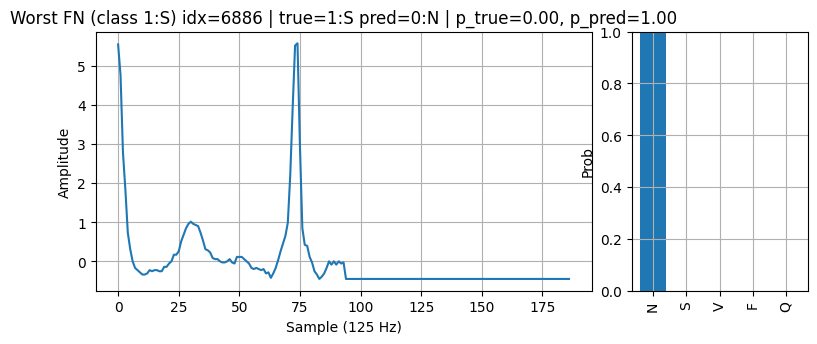

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class1_idx6886.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


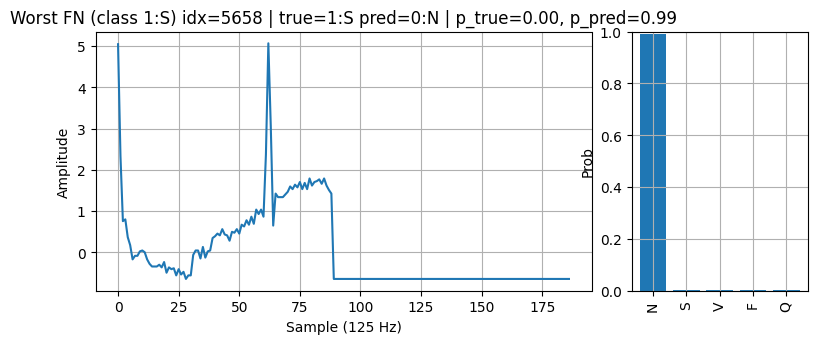

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class1_idx5658.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


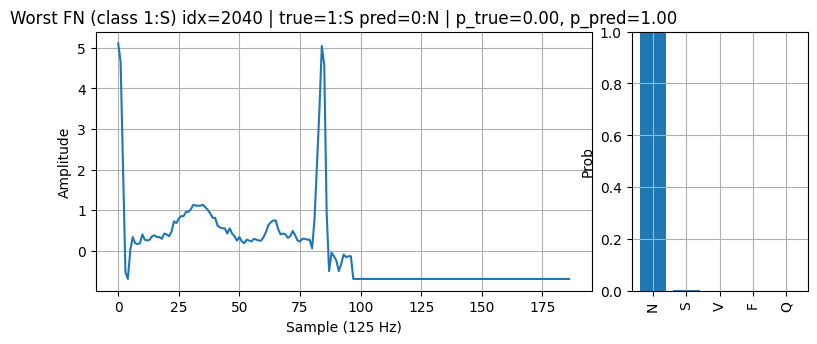

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class1_idx2040.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


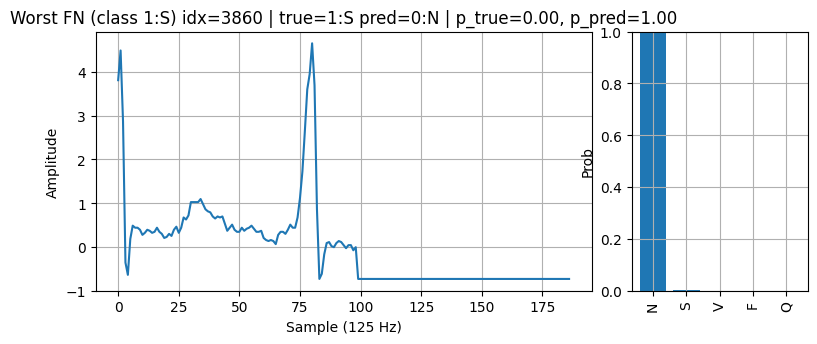

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class1_idx3860.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


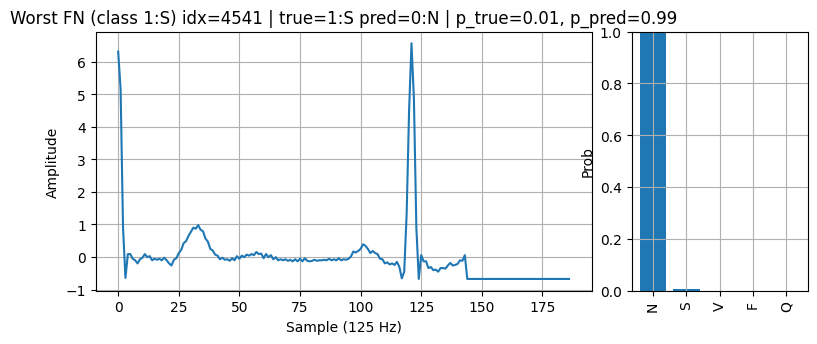

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class1_idx4541.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


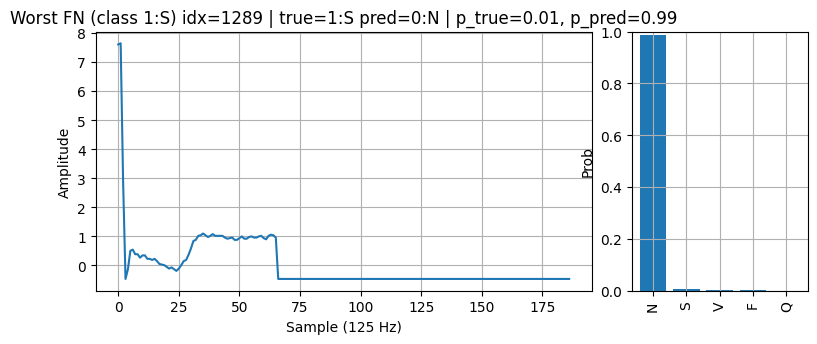

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class1_idx1289.png
Class 1:S — worst FP count=6
Saved: C:\Users\nikhi\Music\ECG\results\errors_worst_FP_class1.csv


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


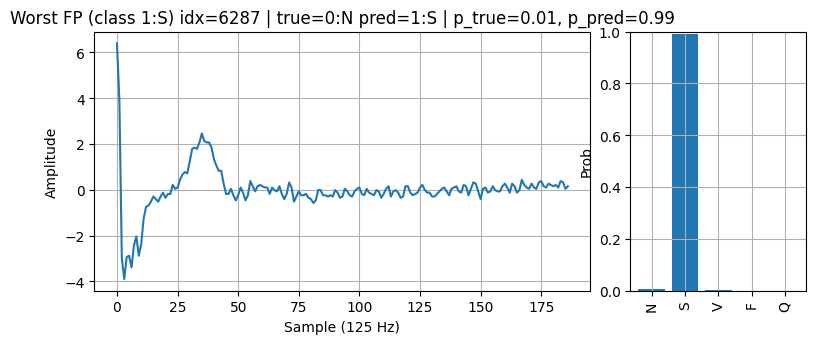

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class1_idx6287.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


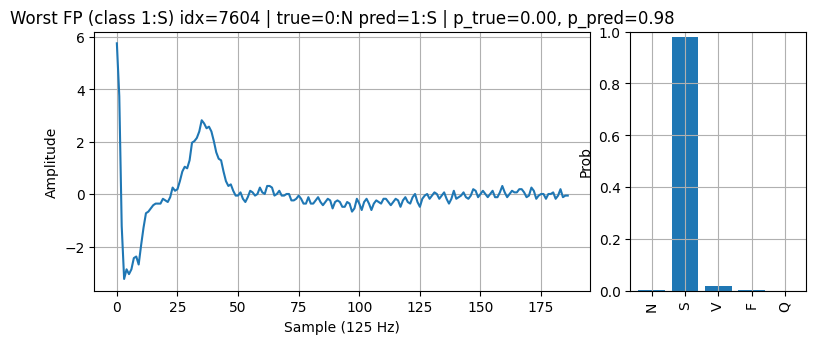

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class1_idx7604.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


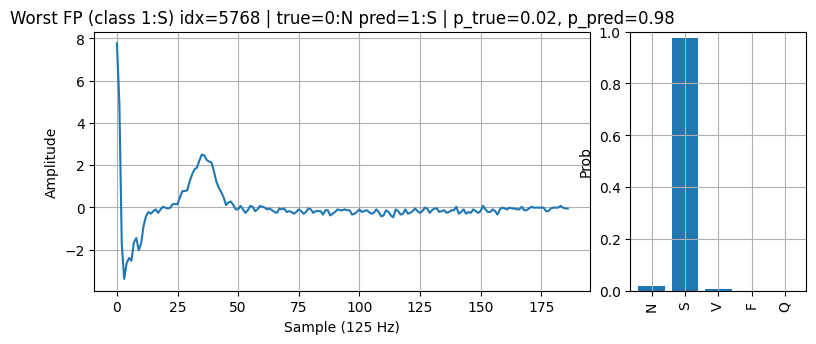

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class1_idx5768.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


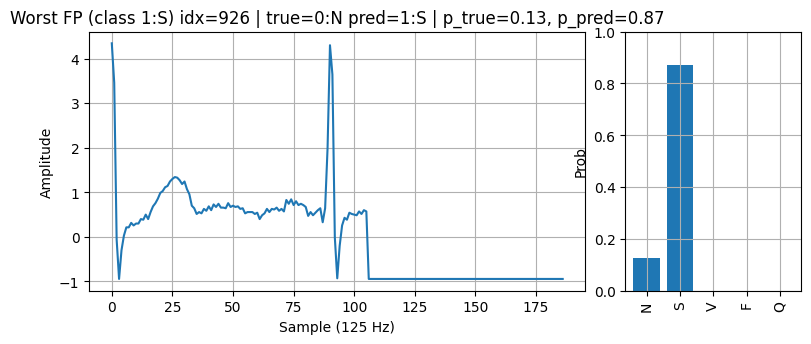

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class1_idx926.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


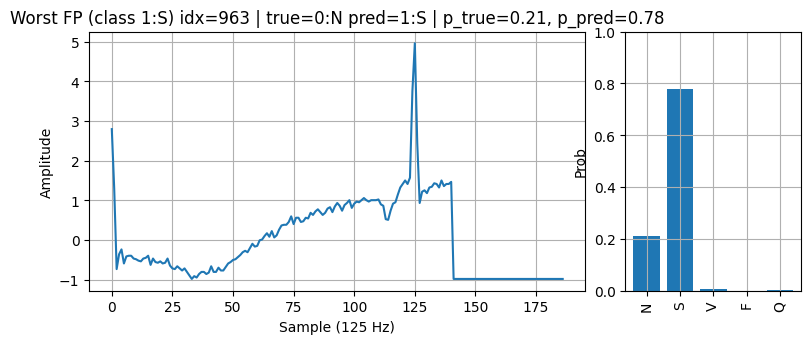

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class1_idx963.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


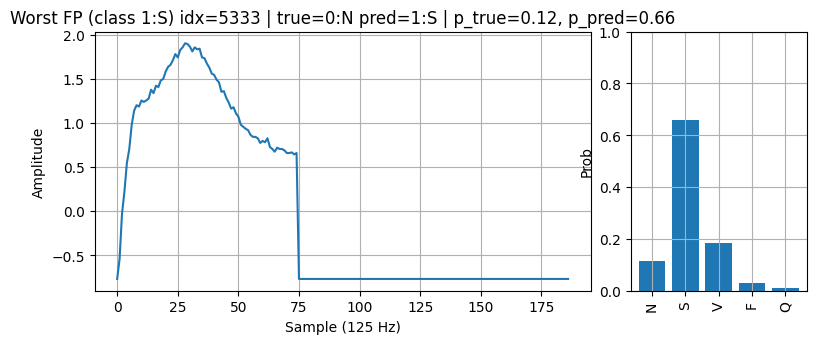

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class1_idx5333.png

Class 3:F — worst FN count=6
Saved: C:\Users\nikhi\Music\ECG\results\errors_worst_FN_class3.csv


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


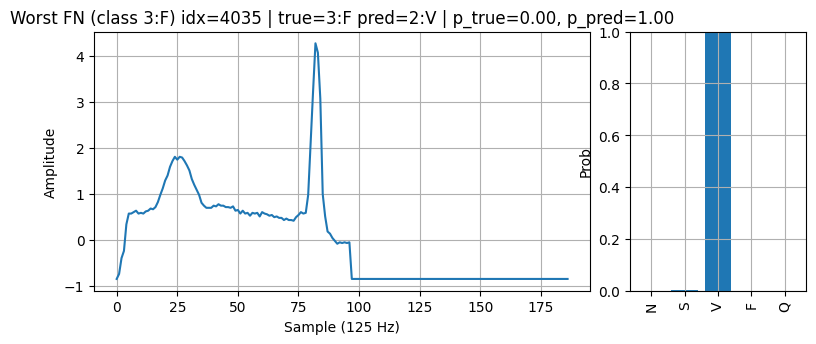

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class3_idx4035.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


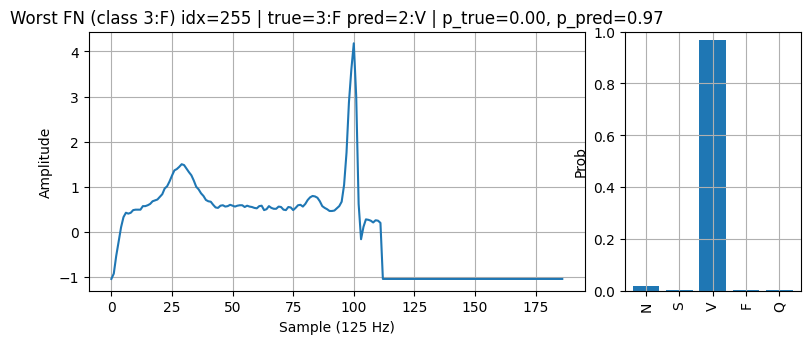

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class3_idx255.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


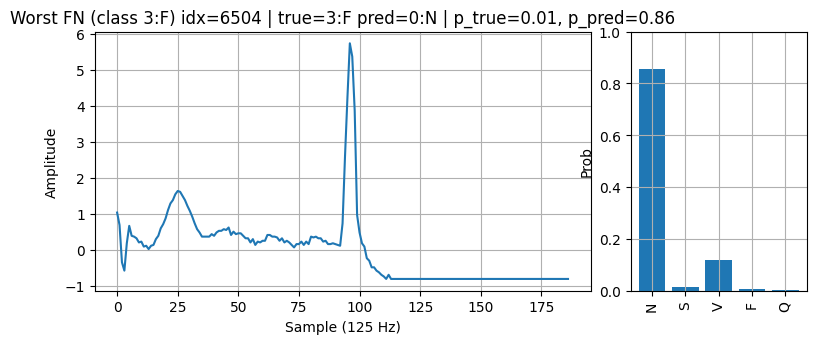

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class3_idx6504.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


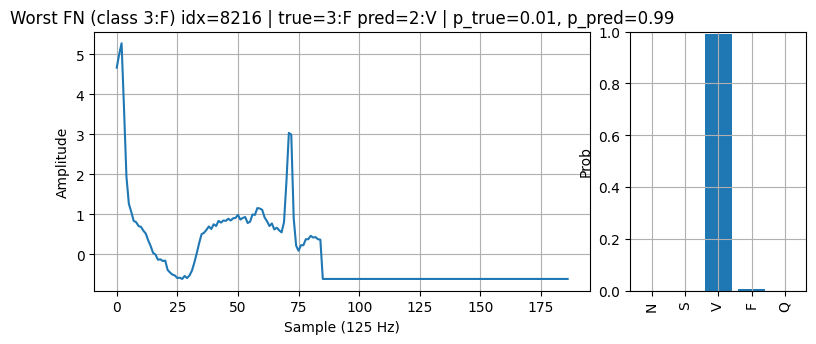

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class3_idx8216.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


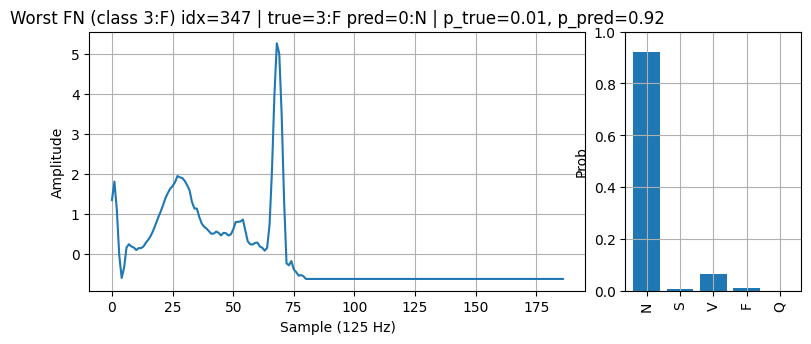

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class3_idx347.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


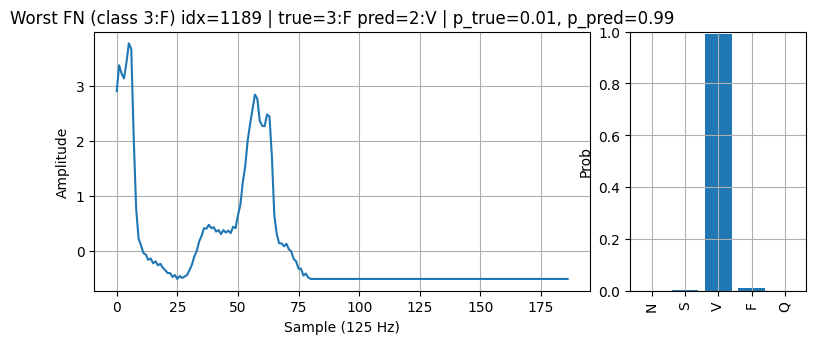

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FN_class3_idx1189.png
Class 3:F — worst FP count=6
Saved: C:\Users\nikhi\Music\ECG\results\errors_worst_FP_class3.csv


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


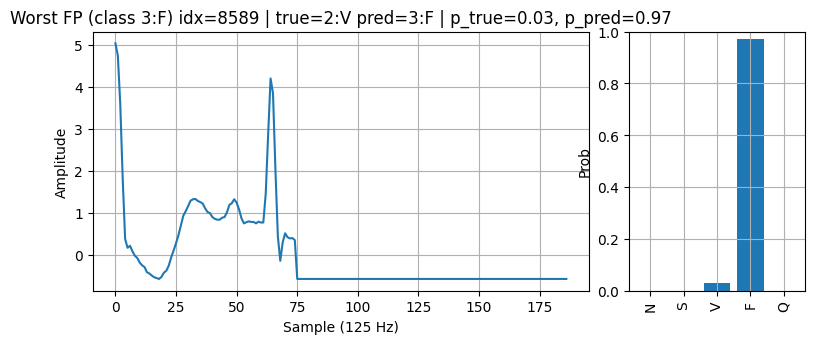

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class3_idx8589.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


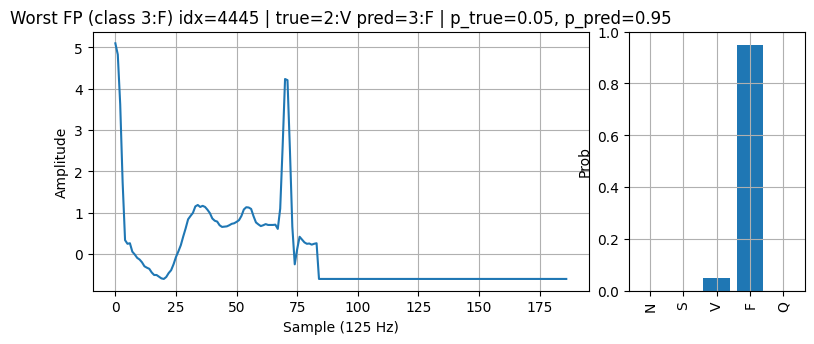

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class3_idx4445.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


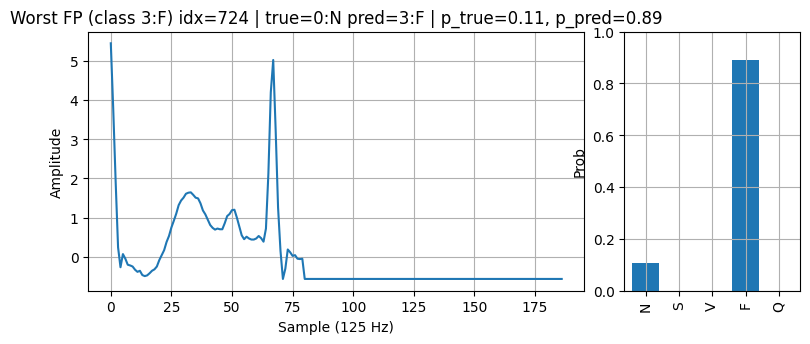

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class3_idx724.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


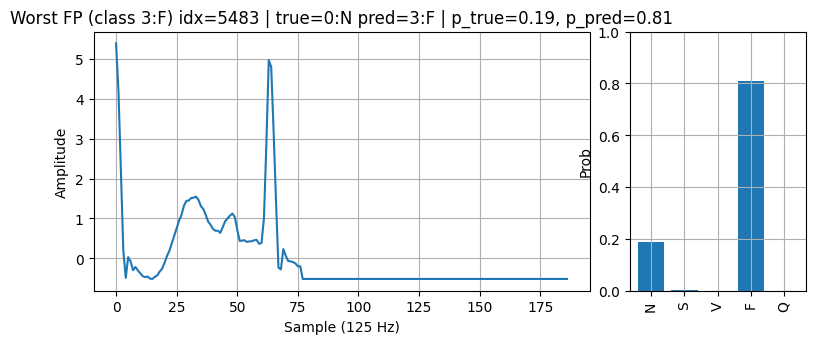

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class3_idx5483.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


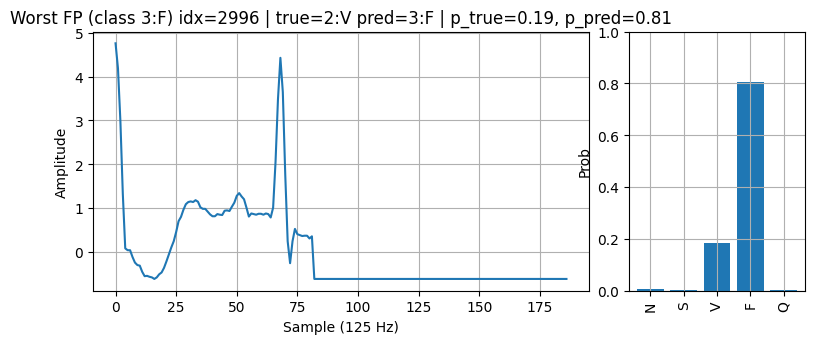

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class3_idx2996.png


C:\Users\nikhi\AppData\Local\Temp\ipykernel_6616\1041240628.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


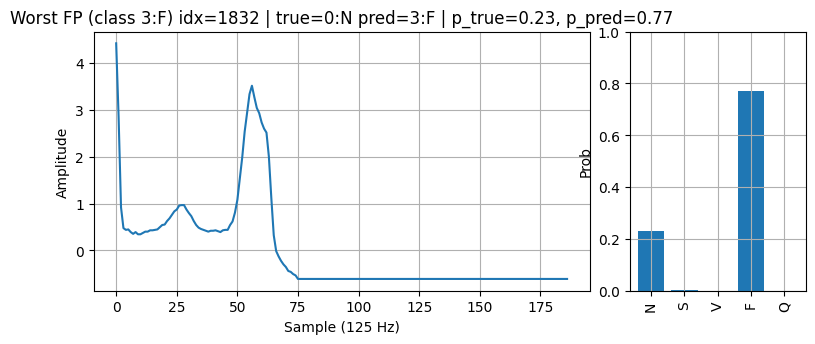

Saved figure: C:\Users\nikhi\Music\ECG\figures\worst_FP_class3_idx1832.png

Done. You now have:
 - error_summary.csv (all samples)
 - errors_worst_FN_class{1,3}.csv & errors_worst_FP_class{1,3}.csv
 - waveform+probability plots for worst FN/FP saved in figures/


In [41]:
# Cell 35E (enhanced): Error analysis — worst FN/FP with plots & CSVs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

assert 'best_name' in globals(), "Run the Validation Leaderboard so best model is set."

# --- config ---
CLASSES_TO_INSPECT = [1, 3]   # focus on S and F
TOP_K = 6                     # how many FN/FP examples to visualize per class
CLASS_NAMES = ["N","S","V","F","Q"]

# --- choose model ---
use_model = calibrated_model if 'calibrated_model' in globals() else best_model
model_label = f"{best_name}{'_cal' if 'calibrated_model' in globals() else ''}"
print(f"Error analysis using: {model_label}")

# --- get probabilities/predictions on VAL ---
if not hasattr(use_model, "predict_proba"):
    raise RuntimeError("Model must support predict_proba. Calibrate first (35B).")

proba_val = use_model.predict_proba(X_val)
pred_val  = proba_val.argmax(axis=1)

# --- build a comprehensive error dataframe ---
conf_true = proba_val[np.arange(len(y_val)), y_val]              # prob assigned to true class
conf_pred = proba_val[np.arange(len(y_val)), pred_val]           # prob assigned to predicted class
is_correct = (pred_val == y_val)

err_df = pd.DataFrame({
    "index": np.arange(len(y_val)),
    "true": y_val,
    "pred": pred_val,
    "conf_true": conf_true,
    "conf_pred": conf_pred,
    "max_conf": proba_val.max(axis=1),
    "correct": is_correct
})
err_df["error_type"] = np.where(err_df["correct"], "TP/Correct", "Error")
err_df_path = RESULTS / "error_summary.csv"
err_df.to_csv(err_df_path, index=False)
print("Saved full error summary:", err_df_path)

# --- helper: plot waveform + probability bars ---
def plot_example(idx, title_prefix=""):
    x = X_val[idx]
    p = proba_val[idx]
    t = int(y_val[idx]); pr = int(pred_val[idx])

    fig = plt.figure(figsize=(8, 3.6))
    # waveform
    ax1 = plt.axes([0.08, 0.18, 0.62, 0.72])
    ax1.plot(x)
    ax1.set_title(f"{title_prefix} idx={idx} | true={t}:{CLASS_NAMES[t]} pred={pr}:{CLASS_NAMES[pr]} | p_true={p[t]:.2f}, p_pred={p[pr]:.2f}")
    ax1.set_xlabel("Sample (125 Hz)"); ax1.set_ylabel("Amplitude")

    # probability bars
    ax2 = plt.axes([0.75, 0.18, 0.22, 0.72])
    ax2.bar(np.arange(5), p)
    ax2.set_xticks(np.arange(5)); ax2.set_xticklabels(CLASS_NAMES, rotation=90)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Prob")
    plt.tight_layout()
    return fig

# --- functions to get worst FN/FP indices for a class ---
def worst_false_negatives(c, k=TOP_K):
    # true=c, predicted!=c; "worst" = lowest confidence on the true class
    mask = (y_val == c) & (pred_val != c)
    idxs = np.where(mask)[0]
    if idxs.size == 0:
        return np.array([], dtype=int)
    conf = proba_val[idxs, c]  # lower is worse
    order = np.argsort(conf)   # ascending
    return idxs[order][:k]

def worst_false_positives(c, k=TOP_K):
    # true!=c, predicted=c; "worst" = highest model confidence for the wrong class
    mask = (y_val != c) & (pred_val == c)
    idxs = np.where(mask)[0]
    if idxs.size == 0:
        return np.array([], dtype=int)
    conf = proba_val[idxs, c]  # higher is worse (over-confident mistakes)
    order = np.argsort(-conf)  # descending
    return idxs[order][:k]

# --- iterate target classes and save artifacts ---
FIGS.mkdir(exist_ok=True)

for c in CLASSES_TO_INSPECT:
    # Worst FN
    fn_idxs = worst_false_negatives(c, TOP_K)
    print(f"\nClass {c}:{CLASS_NAMES[c]} — worst FN count={len(fn_idxs)}")
    out_csv_fn = RESULTS / f"errors_worst_FN_class{c}.csv"
    pd.DataFrame({
        "index": fn_idxs,
        "true": y_val[fn_idxs],
        "pred": pred_val[fn_idxs],
        "p_true": proba_val[fn_idxs, c],
        "p_pred": proba_val[fn_idxs, pred_val[fn_idxs]]
    }).to_csv(out_csv_fn, index=False)
    print("Saved:", out_csv_fn)

    for idx in fn_idxs:
        fig = plot_example(idx, title_prefix=f"Worst FN (class {c}:{CLASS_NAMES[c]})")
        outp = FIGS / f"worst_FN_class{c}_idx{idx}.png"
        fig.savefig(outp, dpi=150); plt.show()
        print("Saved figure:", outp)

    # Worst FP
    fp_idxs = worst_false_positives(c, TOP_K)
    print(f"Class {c}:{CLASS_NAMES[c]} — worst FP count={len(fp_idxs)}")
    out_csv_fp = RESULTS / f"errors_worst_FP_class{c}.csv"
    pd.DataFrame({
        "index": fp_idxs,
        "true": y_val[fp_idxs],
        "pred": pred_val[fp_idxs],
        "p_true": proba_val[fp_idxs, y_val[fp_idxs]],
        "p_pred": proba_val[fp_idxs, c]
    }).to_csv(out_csv_fp, index=False)
    print("Saved:", out_csv_fp)

    for idx in fp_idxs:
        fig = plot_example(idx, title_prefix=f"Worst FP (class {c}:{CLASS_NAMES[c]})")
        outp = FIGS / f"worst_FP_class{c}_idx{idx}.png"
        fig.savefig(outp, dpi=150); plt.show()
        print("Saved figure:", outp)

print("\nDone. You now have:")
print(" - error_summary.csv (all samples)")
print(" - errors_worst_FN_class{1,3}.csv & errors_worst_FP_class{1,3}.csv")
print(" - waveform+probability plots for worst FN/FP saved in figures/")


In [42]:
# Cell 35F: Inference latency & model size (deployment readiness)

import time, tempfile, os, json
import numpy as np
import joblib
from pathlib import Path

# ---- pick active model (calibrated if available) ----
assert 'best_model' in globals(), "Run the Validation Leaderboard first."
active_model = calibrated_model if 'calibrated_model' in globals() else best_model
active_name  = f"{best_name}{'_cal' if 'calibrated_model' in globals() else ''}"
print(f"Benchmarking model: {active_name}")

# ---- simple benchmark helpers ----
def bench_predict(model, X, repeats=5, batch=4096, warmup=True):
    xbatch = X[:batch]
    if warmup:
        _ = model.predict(xbatch)  # warmup call
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model.predict(xbatch)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    mu, sd = float(np.mean(times)), float(np.std(times))
    return mu, sd, batch / max(mu, 1e-12)

def bench_predict_proba(model, X, repeats=5, batch=4096, warmup=True):
    if not hasattr(model, "predict_proba"):
        return None
    xbatch = X[:batch]
    if warmup:
        _ = model.predict_proba(xbatch)
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model.predict_proba(xbatch)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    mu, sd = float(np.mean(times)), float(np.std(times))
    return mu, sd, batch / max(mu, 1e-12)

# ---- run benchmarks ----
BATCH = 4096
REPEATS = 5

pred_mu, pred_sd, pred_throughput = bench_predict(active_model, X_test, repeats=REPEATS, batch=BATCH)
print(f"predict()  — batch={BATCH}: {pred_mu:.3f}s ± {pred_sd:.3f}s  → ~{int(pred_throughput):,} beats/sec  (~{1e3*pred_mu/BATCH:.3f} ms/beat)")

proba_stats = bench_predict_proba(active_model, X_test, repeats=REPEATS, batch=BATCH)
if proba_stats is not None:
    proba_mu, proba_sd, proba_throughput = proba_stats
    print(f"predict_proba() — batch={BATCH}: {proba_mu:.3f}s ± {proba_sd:.3f}s  → ~{int(proba_throughput):,} beats/sec  (~{1e3*proba_mu/BATCH:.3f} ms/beat)")
else:
    print("predict_proba() not available for this model.")

# ---- on-disk model size (pickle) ----
tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".pkl")
tmp_path = tmp.name
tmp.close()
joblib.dump(active_model, tmp_path)
size_mb = os.path.getsize(tmp_path) / (1024 * 1024)
os.unlink(tmp_path)
print(f"Model size (pickle): {size_mb:.2f} MB")

# ---- save JSON summary ----
summary = {
    "model": active_name,
    "batch": BATCH,
    "repeats": REPEATS,
    "predict": {
        "sec_mean": pred_mu,
        "sec_std": pred_sd,
        "throughput_beats_per_sec": pred_throughput,
        "ms_per_beat": (1e3 * pred_mu / BATCH),
    },
    "predict_proba": None if proba_stats is None else {
        "sec_mean": proba_mu,
        "sec_std": proba_sd,
        "throughput_beats_per_sec": proba_throughput,
        "ms_per_beat": (1e3 * proba_mu / BATCH),
    },
    "pickle_size_mb": size_mb,
}
Path(RESULTS).mkdir(exist_ok=True)
with open(RESULTS / "inference_benchmark.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved:", RESULTS / "inference_benchmark.json")


Benchmarking model: XGBoost_cal
predict()  — batch=4096: 3.269s ± 0.031s  → ~1,252 beats/sec  (~0.798 ms/beat)
predict_proba() — batch=4096: 3.265s ± 0.039s  → ~1,254 beats/sec  (~0.797 ms/beat)
Model size (pickle): 70.85 MB
Saved: C:\Users\nikhi\Music\ECG\results\inference_benchmark.json


In [43]:
# Cell 36: Validation leaderboard incl. calibrated + thresholds (robust)

import pandas as pd
import numpy as np

rows = []

# 1) Base models from 32–35 (if available)
if 'f1_val_lr' in globals():   rows.append(("LogReg", float(f1_val_lr)))
if 'f1_val_svm' in globals():  rows.append(("SVM-RBF", float(f1_val_svm)))
if 'f1_val_rf' in globals():   rows.append(("RandomForest", float(f1_val_rf)))
if 'f1_val_xgb' in globals():  rows.append(("XGBoost", float(f1_val_xgb)))

# 2) Calibrated argmax (from 35B)
if 'f1_val_cal' in globals():  rows.append((f"{best_name}_cal", float(f1_val_cal)))

# 3) Calibrated + thresholds (from 35C)
#    We re-evaluate quickly in case the notebook restarted; otherwise use macro_thr we computed.
macro_thr_val = None
if 'thresholds' in globals():
    # recompute safely from current calibrated_model
    assert 'calibrated_model' in globals(), "Thresholds require calibrated_model. Re-run 35B & 35C."
    proba_val = calibrated_model.predict_proba(X_val)
    def predict_with_thresholds(proba, thr):
        arg = proba.argmax(axis=1)
        y_pred = arg.copy()
        for i in range(proba.shape[0]):
            hits = np.where(proba[i] >= thr)[0]
            if len(hits) == 1:
                y_pred[i] = hits[0]
            elif len(hits) > 1:
                y_pred[i] = hits[np.argmax(proba[i, hits])]
        return y_pred
    y_val_thr = predict_with_thresholds(proba_val, thresholds)
    from sklearn.metrics import f1_score
    macro_thr_val = f1_score(y_val, y_val_thr, average='macro')
    rows.append((f"{best_name}_cal+thr", float(macro_thr_val)))

assert len(rows) > 0, "No validation scores found. Run Cells 32–35 and 35B–35C first."

leaderboard = pd.DataFrame(rows, columns=["variant", "val_macro_f1"]).sort_values("val_macro_f1", ascending=False, ignore_index=True)
display(leaderboard)

chosen_variant = leaderboard.iloc[0]["variant"]
print("Chosen validation winner:", chosen_variant)

# Choose the model object + thresholds for test-time
use_thresholds = chosen_variant.endswith("+thr")
if use_thresholds:
    active_model_for_test = calibrated_model
    active_thresholds = thresholds
else:
    # Use calibrated_model if it won; else the raw best_model discovered earlier
    active_model_for_test = calibrated_model if chosen_variant.endswith("_cal") else best_model
    active_thresholds = None

print("Use thresholds on test?:", bool(use_thresholds))


,variant,val_macro_f1
0,XGBoost_cal+thr,0.914779
1,XGBoost,0.912886
2,XGBoost_cal,0.910599
3,RandomForest,0.844521
4,SVM-RBF,0.535145
5,LogReg,0.491022


Chosen validation winner: XGBoost_cal+thr
Use thresholds on test?: True


[TEST] macro-F1 (XGBoost_cal+thr): 0.9117
              precision    recall  f1-score   support

           N     0.9847    0.9965    0.9906     18118
           S     0.9258    0.7176    0.8085       556
           V     0.9720    0.9351    0.9532      1448
           F     0.8452    0.8086    0.8265       162
           Q     0.9892    0.9708    0.9799      1608

    accuracy                         0.9821     21892
   macro avg     0.9434    0.8857    0.9117     21892
weighted avg     0.9817    0.9821    0.9815     21892



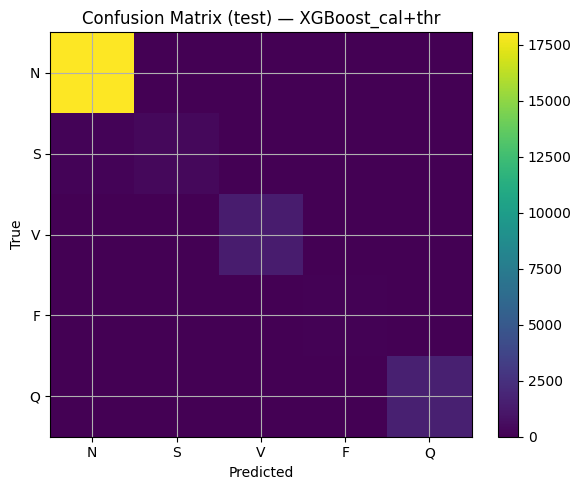

Saved: C:\Users\nikhi\Music\ECG\figures\cm_test_XGBoost_cal_thr.png


In [44]:
# Cell 37: Final test evaluation (supports calibrated + thresholds)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix

assert 'active_model_for_test' in globals(), "Run Cell 36 to select the winner."

def predict_with_thresholds(proba, thr):
    arg = proba.argmax(axis=1)
    y_pred = arg.copy()
    for i in range(proba.shape[0]):
        hits = np.where(proba[i] >= thr)[0]
        if len(hits) == 1:
            y_pred[i] = hits[0]
        elif len(hits) > 1:
            y_pred[i] = hits[np.argmax(proba[i, hits])]
    return y_pred

variant_name = chosen_variant  # from Cell 36

if active_thresholds is None:
    # Argmax evaluation
    if hasattr(active_model_for_test, "predict_proba"):
        proba_test = active_model_for_test.predict_proba(X_test)
    y_pred_test = active_model_for_test.predict(X_test)
else:
    # Thresholded evaluation requires probabilities
    assert hasattr(active_model_for_test, "predict_proba"), "Thresholded inference requires predict_proba."
    proba_test = active_model_for_test.predict_proba(X_test)
    y_pred_test = predict_with_thresholds(proba_test, active_thresholds)

# Compute metrics
macro_f1_test = f1_score(y_test, y_pred_test, average="macro")
print(f"[TEST] macro-F1 ({variant_name}): {macro_f1_test:.4f}")
print(classification_report(y_test, y_pred_test, target_names=["N","S","V","F","Q"], digits=4))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_test, labels=[0,1,2,3,4])
plt.figure(figsize=(6,5))
plt.imshow(cm, aspect='auto')
plt.title(f"Confusion Matrix (test) — {variant_name}")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(5), ["N","S","V","F","Q"]); plt.yticks(range(5), ["N","S","V","F","Q"])
plt.colorbar(); plt.tight_layout()
outp = FIGS / f"cm_test_{variant_name.replace('+','_')}.png"
plt.savefig(outp, dpi=150); plt.show()
print("Saved:", outp)

# Keep artifacts handy for Cell 38
test_y_pred = y_pred_test


In [45]:
# Cell 38: Persist final Phase 3 artifacts (winner model + thresholds + metrics)

import json, joblib
from pathlib import Path
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

Path(PROJ / "models").mkdir(exist_ok=True)

# Save the final model used for test
if active_thresholds is None and active_model_for_test is best_model:
    # best raw model path
    model_path = PROJ / "models" / f"{best_name}_best_phase3.pkl"
    joblib.dump(active_model_for_test, model_path)
else:
    # most likely calibrated model
    suffix = variant_name.replace("+","_")
    model_path = PROJ / "models" / f"{suffix}_final.pkl"
    joblib.dump(active_model_for_test, model_path)

print("Saved model:", model_path)

# Save thresholds (if any)
thr_path = None
if active_thresholds is not None:
    thr_path = RESULTS / "per_class_thresholds_final.json"
    with open(thr_path, "w") as f:
        json.dump({"variant": variant_name, "thresholds": active_thresholds.tolist()}, f, indent=2)
    print("Saved thresholds:", thr_path)

# Save predictions & reports
pred_path = RESULTS / f"test_predictions_{variant_name.replace('+','_')}.csv"
pd.DataFrame({"y_true": y_test, "y_pred": test_y_pred}).to_csv(pred_path, index=False)
print("Saved predictions:", pred_path)

report_text = classification_report(y_test, test_y_pred, target_names=["N","S","V","F","Q"], digits=4)
with open(RESULTS / f"classification_report_test_{variant_name.replace('+','_')}.txt", "w") as f:
    f.write(report_text)
print("Saved classification report (txt).")

cm = confusion_matrix(y_test, test_y_pred, labels=[0,1,2,3,4])
cm_path = RESULTS / f"confusion_test_{variant_name.replace('+','_')}.csv"
pd.DataFrame(cm, index=["N","S","V","F","Q"], columns=["N","S","V","F","Q"]).to_csv(cm_path)
print("Saved confusion matrix:", cm_path)

# Save a compact JSON summary
summary = {
    "winner_variant": variant_name,
    "model_path": str(model_path),
    "thresholds_path": str(thr_path) if thr_path is not None else None,
    "test_macro_f1": float(f1_score(y_test, test_y_pred, average='macro')),
}
with open(RESULTS / "phase3_final_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved:", RESULTS / "phase3_final_summary.json")


Saved model: C:\Users\nikhi\Music\ECG\models\XGBoost_cal_thr_final.pkl
Saved thresholds: C:\Users\nikhi\Music\ECG\results\per_class_thresholds_final.json
Saved predictions: C:\Users\nikhi\Music\ECG\results\test_predictions_XGBoost_cal_thr.csv
Saved classification report (txt).
Saved confusion matrix: C:\Users\nikhi\Music\ECG\results\confusion_test_XGBoost_cal_thr.csv
Saved: C:\Users\nikhi\Music\ECG\results\phase3_final_summary.json
